In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import keras 


df = pd.read_pickle('dataset/train_dataset_median.pkl')
# df = pd.read_pickle('dataset/train_dataset.pkl')
df['Normal/Attack'] = df['Normal/Attack'].apply(lambda x: 0 if x == 'Normal' else 1)

pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None) #50 for truncated view, -1 for full view

# Process-aware ML Based Intrusion Detection for Industrial Control Systems

In [2]:

def get_train_test_dataset(df):
    split_date = '2015-12-28 10:29:13'
    data_train = df.loc[df['Timestamp'] <= split_date].copy()
    data_test = df.loc[df['Timestamp'] > split_date].copy()

    return data_train, data_test


In [3]:
train, test = get_train_test_dataset(df)
test = test.reset_index(drop=True)

train['Normal/Attack'].replace(['Normal', 'Attack'], [0, 1], inplace=True)
test['Normal/Attack'].replace(['Normal', 'Attack'], [0, 1], inplace=True)


In [3]:
cols_numeric = list(df.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('index')
cols_numeric.remove('attack')

# for col in cols_continuous_tank:
#     cols_numeric.remove(col)

cols_discrete = []
cols_continuous = []

for col in cols_numeric:
    
    if len(df[col].unique()) <= 5:
        cols_discrete.append(col)
    else:
        cols_continuous.append(col)

Get the slope

In [22]:
def diff_num(a, n):
    for i in range(n, len(a)):
        if i == 0:
            yield 0
        else:
            yield a[i] - a[i-n]

In [1093]:
attack_df = pd.read_csv('attacks_df.csv')
attack_df['start_time'] = pd.to_datetime(attack_df['start_time'])
attack_df['end_time'] = pd.to_datetime(attack_df['end_time'])

def get_timestamp_attack(index_attack, offset):
    index_attack = attack_df[attack_df['num_attack'] == index_attack].index[0]
    index_start = df[df['Timestamp'] == attack_df.iloc[index_attack]['start_time']].index[0] - offset
    if offset + df[df['Timestamp'] == attack_df.iloc[index_attack]['end_time']].index[0] > len(df):
        offset = len(df) - df[df['Timestamp'] == attack_df.iloc[index_attack]['end_time']].index[0]
    index_end = df[df['Timestamp'] == attack_df.iloc[index_attack]['end_time']].index[0] + offset
    return index_start, index_end

In [51]:

def get_index_attack(attack_name):
    list_attack_index = []
    for i, attack in zip(attack_df['num_attack'], attack_df['attack']):
        attack = attack.replace('-', '')
        if attack_name in attack:
            list_attack_index.append(i)
    return list_attack_index

# FTT

In [7]:
def fft_denoiser(x, n_components, to_real=True):
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

In [17]:

normalization = StandardScaler()
df_normalized = normalization.fit_transform(df[cols_numeric])
df_normalized = pd.DataFrame(df_normalized, columns=cols_numeric)
df_normalized['Timestamp'] = df['Timestamp']


train_normalized, test_normalized = get_train_test_dataset(df_normalized)

In [18]:
feature = 'LIT301'

In [57]:

# n = 100

# for col in cols_continuous:
#     median_ = pd.DataFrame(columns=['x', 'y'])
#     for i in range(0, len(df_normalized), n):
#         med = np.median(df_normalized.iloc[i:i+n][col])
#         a = n
#         if i+n > len(df_normalized):
#             a = len(df_normalized) - i
#         median_ = pd.concat(objs=[median_, pd.DataFrame({'x': [i for i in range(i, i+a)], 'y': [med for i in range(i, i+a)]})], axis=0)
#     df[f'{col}_median'] = median_['y'].reset_index(drop=True)
    
# # ~38 mins

In [58]:
# df.to_pickle('dataset/train_dataset_median.pkl')

In [12]:
df = pd.read_pickle('dataset/train_dataset_median.pkl')

## Test the slope on the median

In [6]:
feature = 'LIT301'

In [17]:
train, test = get_train_test_dataset(df)

In [18]:
feature_median = train[f'{feature}_median'].to_frame()

Get the slope on the median feature

In [54]:
train, test = get_train_test_dataset(df)

def set_median_feature(df, feature):
    feature_median = train[f'{feature}_median'].to_frame()

    feature_slope = [0] * 1 + [ np.abs(x) for x in np.diff(np.array(feature_median[f'{feature}_median']))]# 1 if x > 0 else -1 for

    feature_slope = pd.DataFrame(feature_slope, columns=[f'{feature}_slope'])

    feature_slope_not_0 = feature_slope[feature_slope[f'{feature}_slope'] != 0] 

    median_de = np.quantile(feature_slope_not_0, 0.9)

In [55]:
feature_median = df[f'{feature}_median'].to_frame()

feature_slope = [0] * 1 + [ np.abs(x) for x in diff_num(np.array(feature_median[f'{feature}_median']), 1)]# 1 if x > 0 else -1 for

feature_slope = pd.DataFrame(feature_slope, columns=[f'{feature}_slope'])

feature_slope_not_0 = feature_slope[feature_slope[f'{feature}_slope'] != 0] 


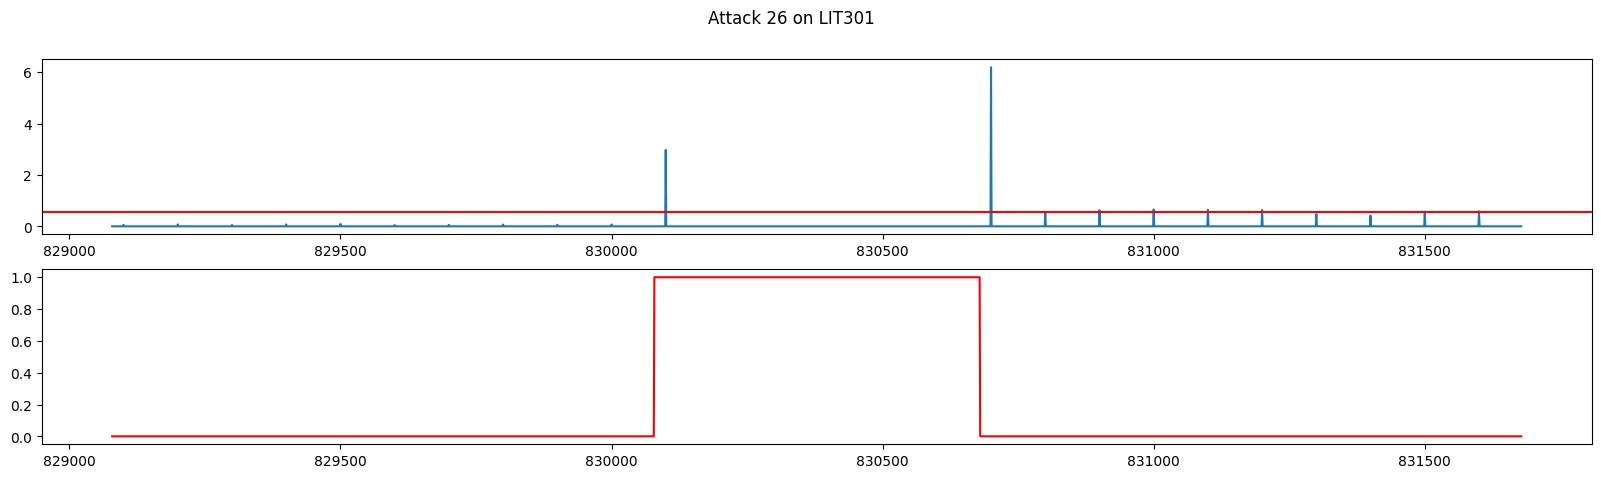

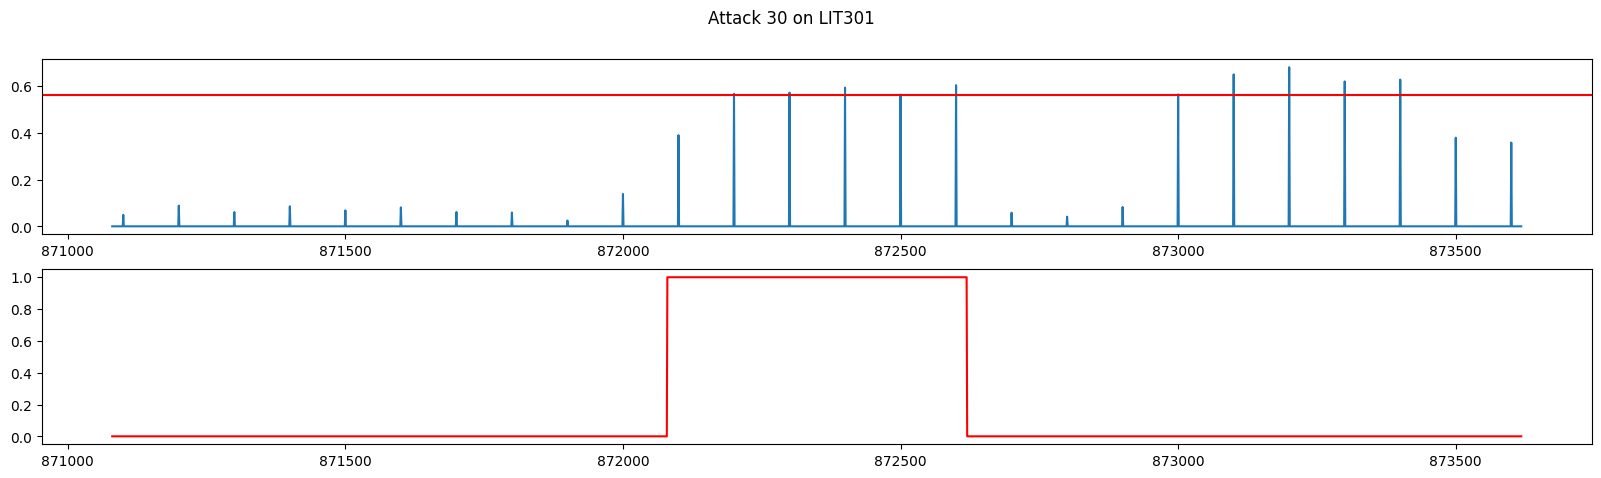

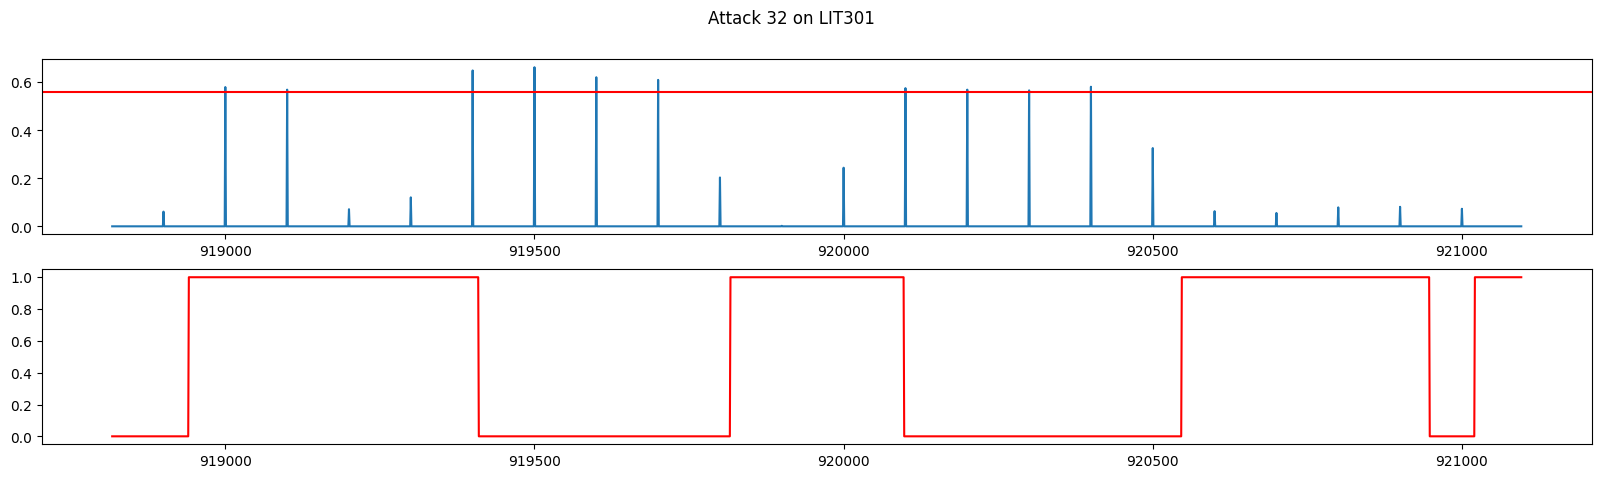

In [56]:
for attack in get_index_attack('LIT301'):

    index_min, index_max = get_timestamp_attack(index_attack=attack, offset=1000)
    
    fig, ax = plt.subplots(2, 1, figsize=(20, 5))
    
    ax[0].plot(pd.DataFrame(feature_slope[f'{feature}_slope'].reset_index(drop=True)).iloc[index_min:index_max])
    ax[0].axhline(y=median_de, color='r', linestyle='-')
    ax[1].plot(df['Normal/Attack'][index_min:index_max], color='red')
    fig.suptitle(f'Attack {attack} on {feature}')
    plt.show()

In [20]:

n = 100
denoiser = []
for i in range(0, len(df_normalized), n):
    x = fft_denoiser(df_normalized.iloc[i:i+n][feature], 20)
    denoiser = np.append(denoiser, x)

In [21]:

x_slope_denoiser = [0] * 1 + [ x for x in diff_num(np.array(median_['y']), 1)]#1 if x > 0 else -1 for

slope_denoiser = pd.DataFrame(x_slope_denoiser, columns=['slope_denoiser'])
slope = slope_denoiser['slope_denoiser'].apply(lambda x: np.abs(x) if x != 0 else 0)

In [22]:
all_median = [slope[x] for x in range(0, len(slope), 100) if slope[x] > 0]
median_de = np.quantile(all_median, 0.95)

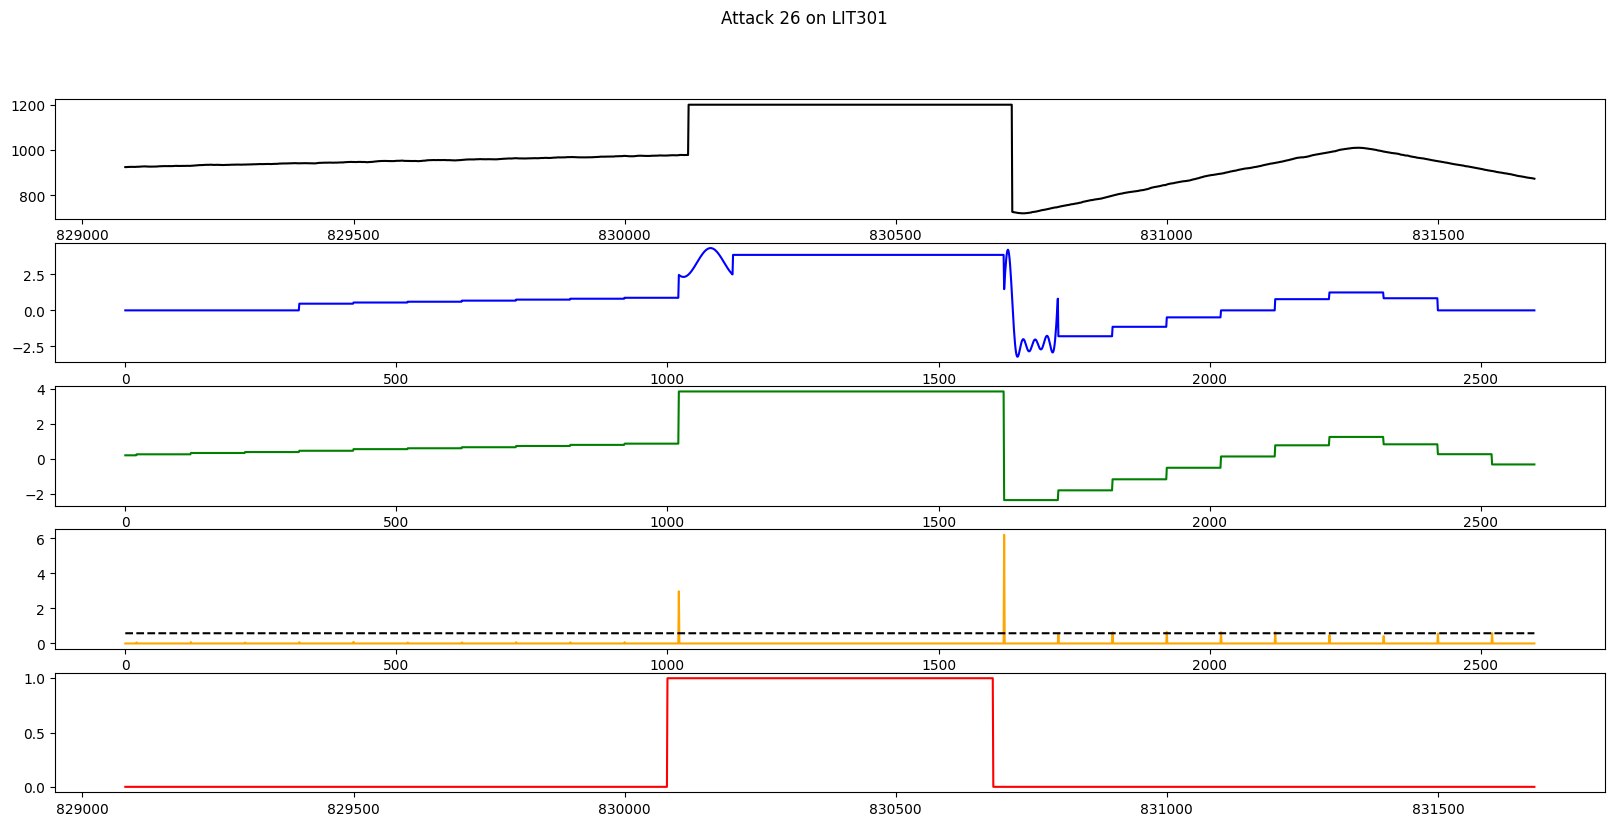

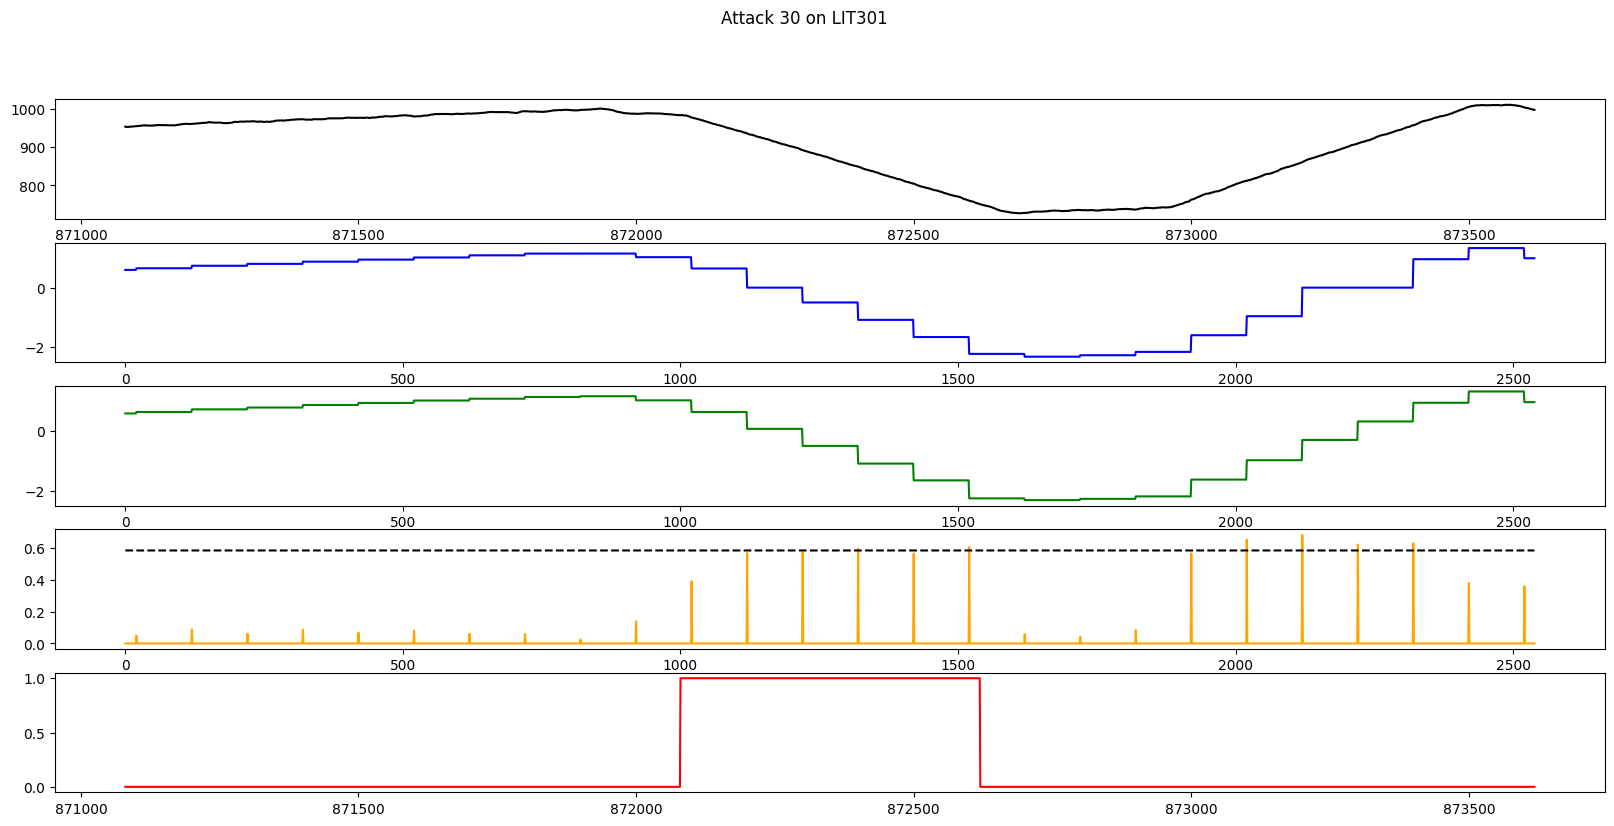

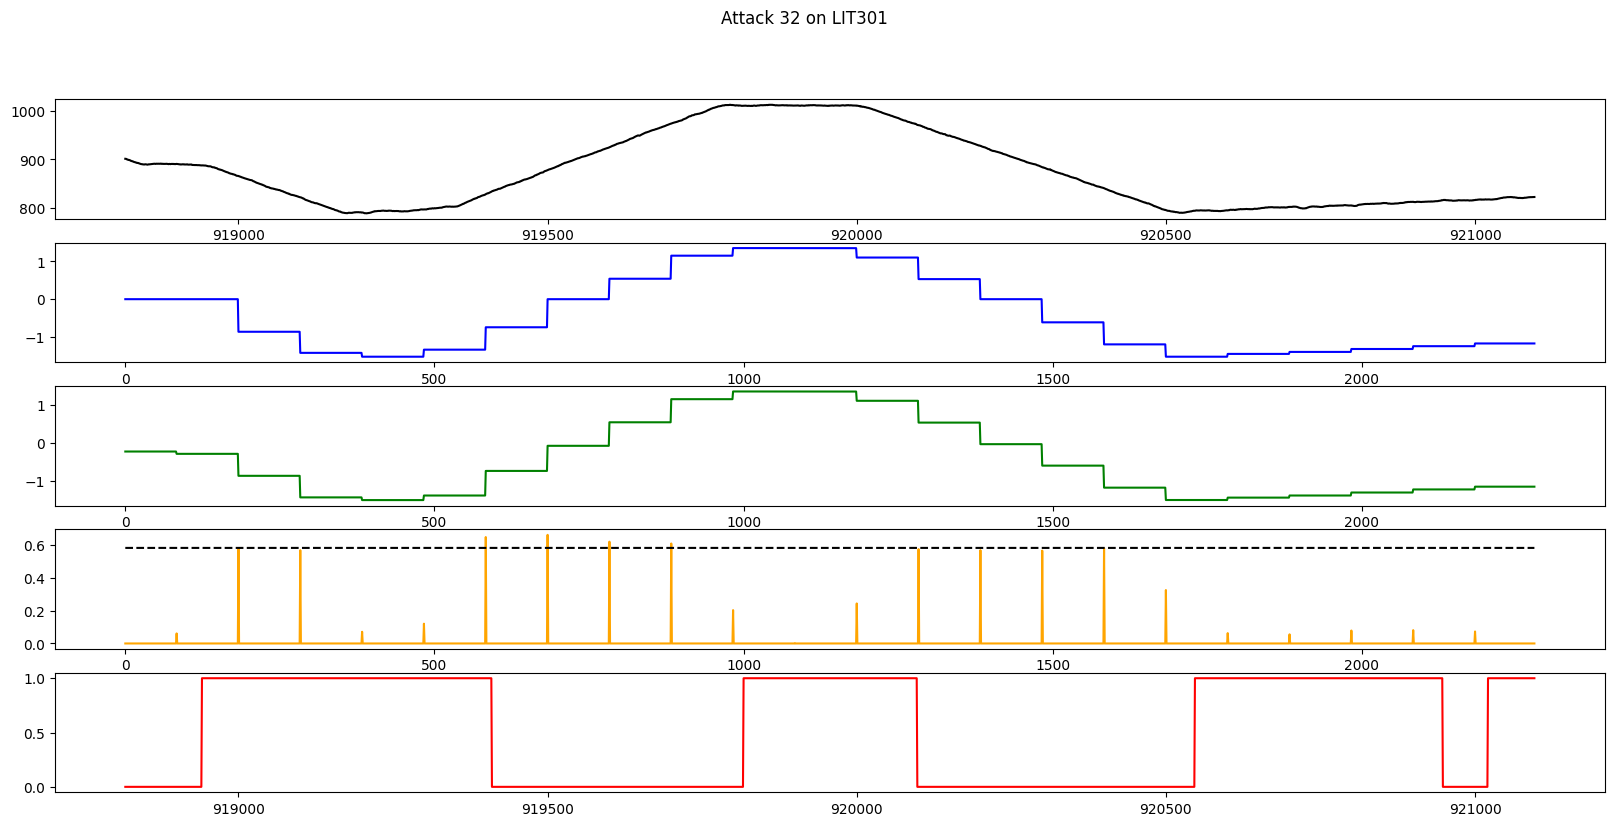

In [26]:
for attack in get_index_attack('LIT301'):
    
    fig, ax = plt.subplots(5, 1, figsize=(20, 9))

    index_min, index_max = get_timestamp_attack(index_attack=attack, offset=1000)

    ax[0].plot(df[feature][index_min:index_max], color='black')
    ax[1].plot(np.array(denoiser)[index_min:index_max], color='blue')
    ax[2].plot(np.array(median_['y'])[index_min:index_max], color='green')
    ax[3].plot(slope[index_min:index_max].reset_index(drop=True), color='orange')
    ax[3].plot([median_de for i in range(index_max-index_min)], color='black', linestyle='--')
    ax[4].plot(df['Normal/Attack'][index_min:index_max], color='red')
    fig.suptitle(f'Attack {attack} on {feature}')
    plt.show()

/home/guillaume/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/guillaume/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NameError: name 'fft_denoise' is not defined

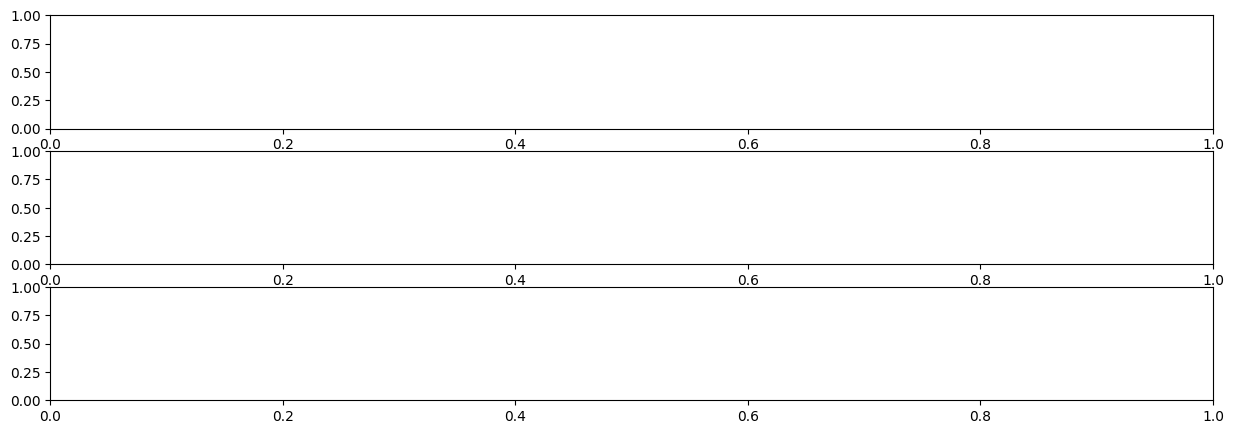

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(15, 5))

index_min = 0
index_max = 25000

median_de = np.median(denoiser) 
ax[0].plot(pd.DataFrame(fft_denoise).iloc[index_min:index_max], color = 'red')
ax[0].plot(pd.DataFrame(data).iloc[index_min:index_max]-1, color='black')


median_['slope'] = median_[['denoiser', 'y']].apply(lambda x: 1 if x[0] > x[1] else -1, axis=1)

# x_slope_denoiser = [0] * 1 + [1 if x > median_de else -1 for x in np.array(median_['denoiser'])]
x_slope_denoiser = [0] * 1 + [ x for x in diff_num(np.array(median_['denoiser']), 1)]#1 if x > 0 else -1 for

# x_slope_fft_denoise = [0] * 1 + [1 if x > 0 else -1 for x in diff_num(fft_denoise, 1)]
# x_slope_data = [0] * 1 + [1 if x > 0 else -1 for x in diff_num(data, 1)]



ax[0].plot(pd.DataFrame(denoiser).iloc[index_min:index_max].reset_index(drop=True), color='blue')
ax[0].plot(df_normalized.iloc[index_min:index_max][feature].reset_index(drop=True), color='green')
ax[0].axhline(y=median_de , color='black', linestyle='--')

ax[1].plot(np.array(median_['y'].iloc[index_min:index_max].reset_index(drop=True)), color='green')
# ax[1].plot(np.array(median_['slope'].iloc[index_min:index_max].reset_index(drop=True)), color='green')


ax[2].plot(x_slope_denoiser[index_min:index_max], color='black')

ax[2].plot(np.array(median_['slope'].iloc[index_min:index_max].reset_index(drop=True) )-2.2, color='blue')
# ax[1].plot(x_slope_fft_denoise[index_min:index_max], color='red')
# ax[1].plot(pd.DataFrame(x_slope_data).iloc[index_min:index_max]-2.2, color='black')
plt.show()

## Isolation Forest

In [60]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as score


In [62]:
# df_backup = df.copy()

In [63]:
df = pd.read_pickle('dataset/train_dataset_median.pkl')

In [58]:
cols_numeric = list(df.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('index')
cols_numeric.remove('attack')

cols_discrete = []
cols_continuous = []

for col in cols_numeric:
    
    if len(df[col].unique()) <= 5:
        cols_discrete.append(col)
    else:
        cols_continuous.append(col)


In [68]:
train, test = get_train_test_dataset(df)

In [69]:
y_test = test['Normal/Attack']

In [70]:
def measure_performance(model, X_test, y_true, map_labels):
    
    df_pred_test = X_test.copy()
    df_pred_test['Normal/Attack'] = model.predict(X_test)
    if map_labels:
        df_pred_test['Normal/Attack'] = df_pred_test['Normal/Attack'].map({1: 0, -1: 1})
    x_pred = df_pred_test['Normal/Attack'] 
    matrix = confusion_matrix(x_pred, y_true)

    sns.heatmap(pd.DataFrame(matrix, columns = ['Actual', 'Predicted']),
                xticklabels=['Normal [0]', 'Attack [1]'], 
                yticklabels=['Normal [0]', 'Attack [1]'], 
                annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    
    print(classification_report(x_pred, y_true))
    
    model_score = score(x_pred, y_true,average='macro')
    print(f'f1_score: {np.round(model_score[2]*100, 2)}%')
    
    return model_score

In [59]:
discrete_cols = []
for col in df.columns:
    if 'median' in col or col in cols_discrete:
        discrete_cols.append(col)

discrete_cols.remove('Normal/Attack')

In [60]:
train_feature = train[discrete_cols]
test_feature = test[discrete_cols]

<AxesSubplot:>

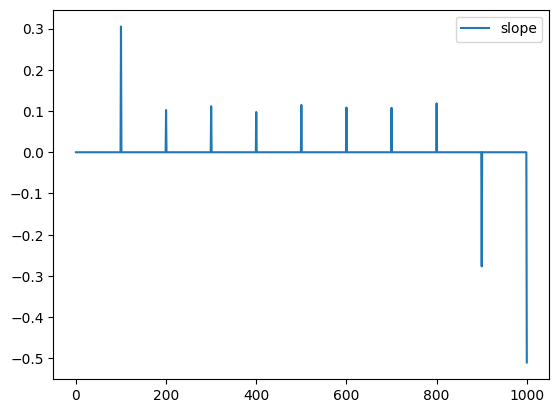

In [165]:
slope_x.iloc[0:1001].plot()

<AxesSubplot:>

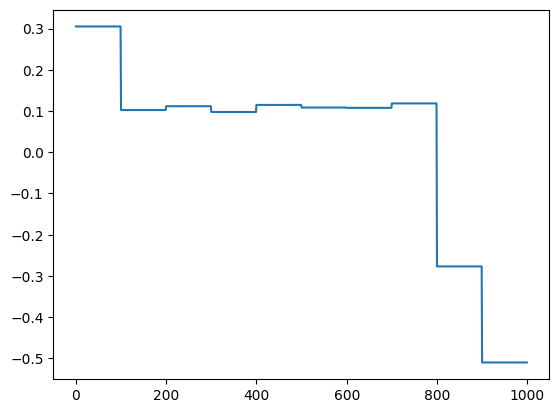

In [164]:
df_copy['slope'].iloc[0:1000].plot()

In [248]:
slope = [0] * 1 + [ x for x in diff_num(np.array(df['LIT101']), 1)]# 1 if x > 0 else -1 for


In [251]:
slope = pd.DataFrame(slope, columns=['slope'])

In [281]:
slope['Timestamp'] = df['Timestamp']

In [291]:
df_merge = pd.merge(df, acc, on='Timestamp', how='right')

In [294]:
df_merge['Normal/Attack'].value_counts()

1    2634
0      61
Name: Normal/Attack, dtype: int64

In [239]:
def get_slope_feature(df, col, window_size):
    df_copy = df[col].copy()

    slope_feature = [0] * 1 + [ x for x in diff_num(np.array(df_copy[col]), 1)]#1 if x > 0 else -1 for

    slope_x = pd.DataFrame(slope_feature, columns=['slope'])
    
    slope_adjusted = []
    for i in range(0, len(slope_x), n):
        
        a = window_size
        if i+window_size > len(slope_x):
            a = len(slope_x) - i
            slope_adjusted += [slope_x['slope'].iloc[i+a-1] for x in range(a)]
        else:
            slope_adjusted += [slope_x['slope'].iloc[i+a] for x in range(a)]
    
    return pd.DataFrame(slope_adjusted)

In [241]:
for col in median_cols:
    slope_feature = get_slope_feature(df, [col], 100)
    df[col+'_slope'] = slope_feature


In [295]:
train, test = get_train_test_dataset(df)

In [229]:

median_threshold = np.quantile(train['slope'], [0.05, 0.95])


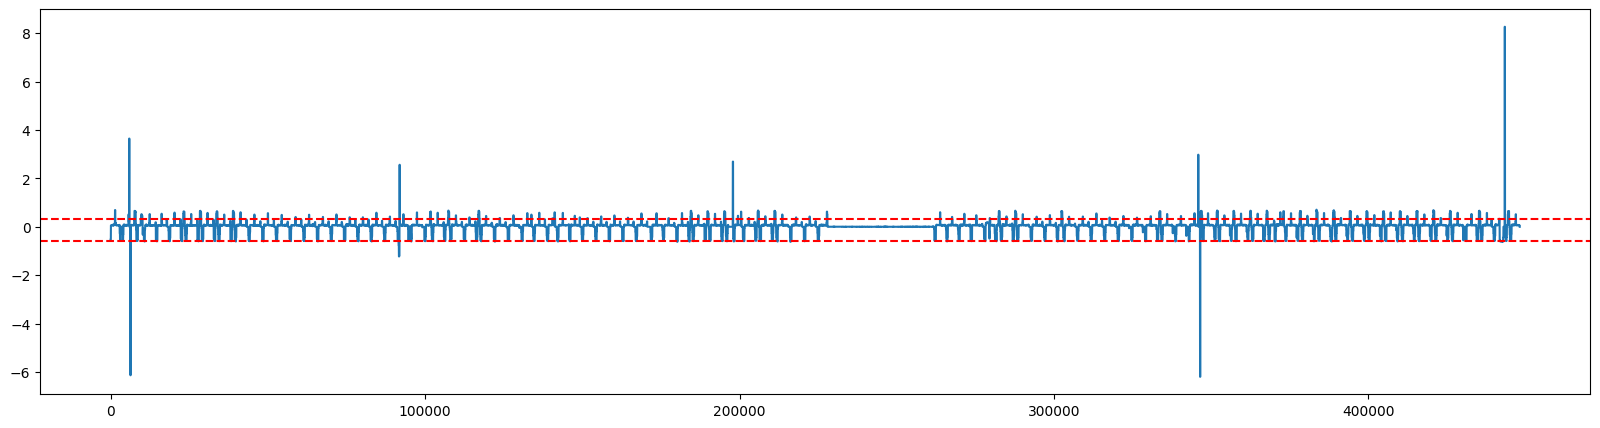

In [232]:

fig, ax = plt.subplots(figsize=(20, 5))
test_copy['slope'].reset_index(drop=True).plot()
ax.axhline(y=median_threshold[0], color='red', linestyle='--')
ax.axhline(y=median_threshold[1], color='red', linestyle='--')


In [243]:
train, test = get_train_test_dataset(df)

IndexError: single positional indexer is out-of-bounds

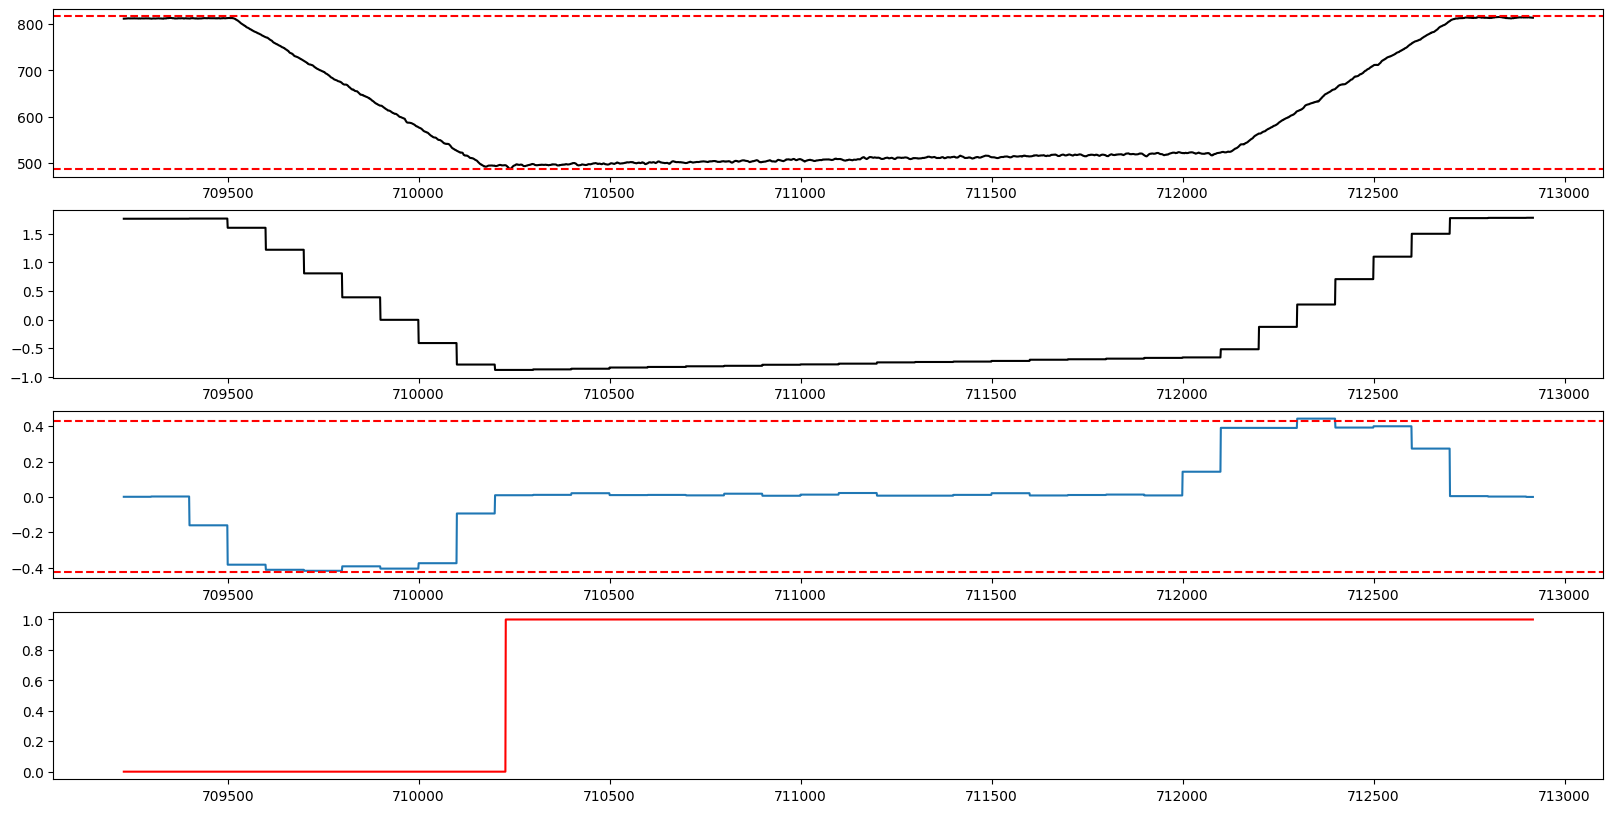

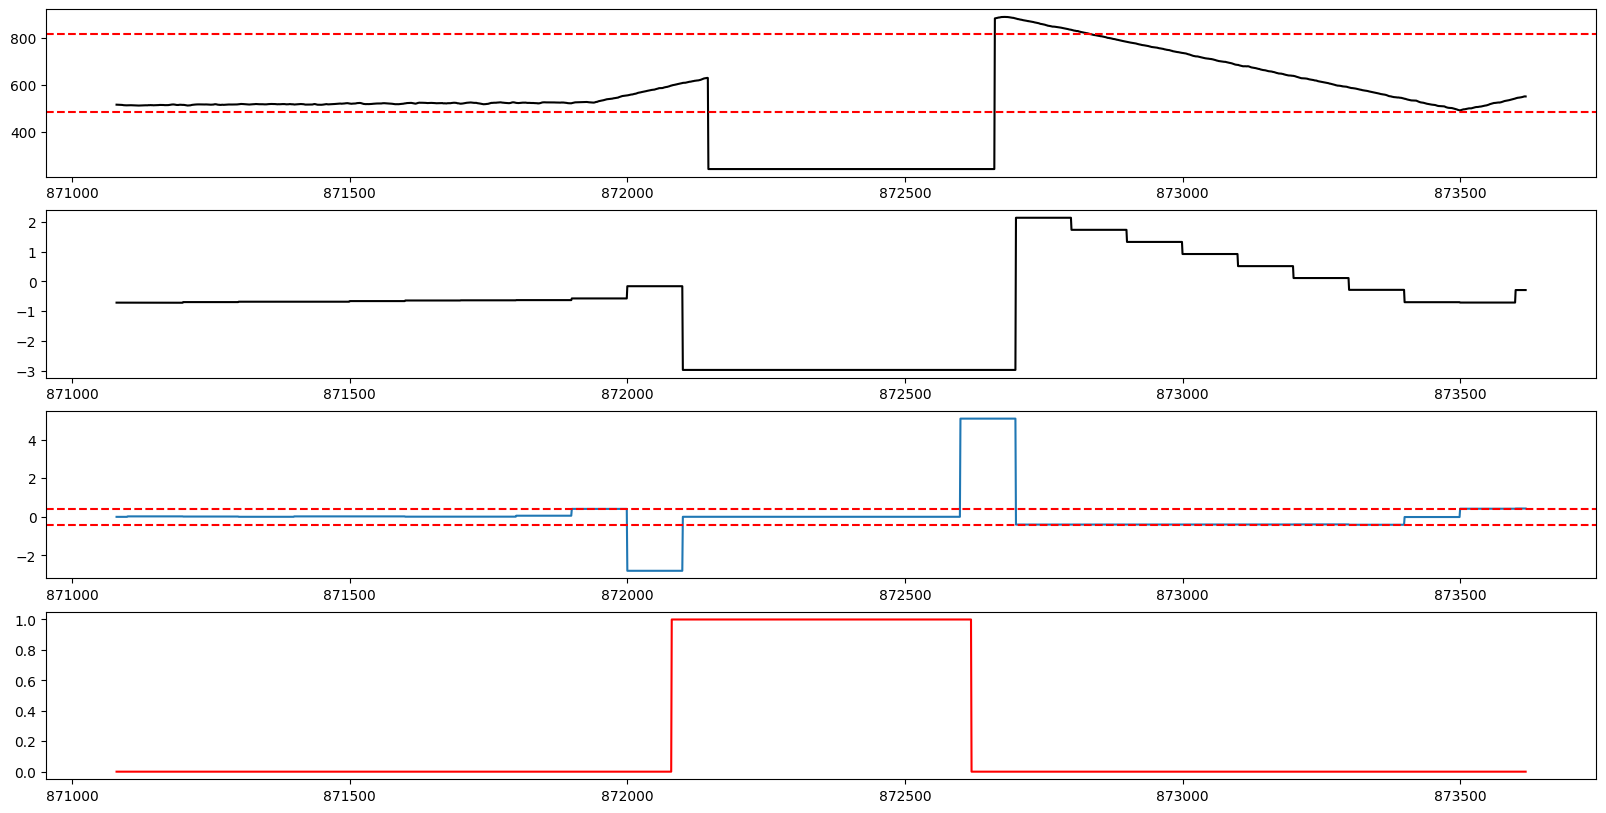

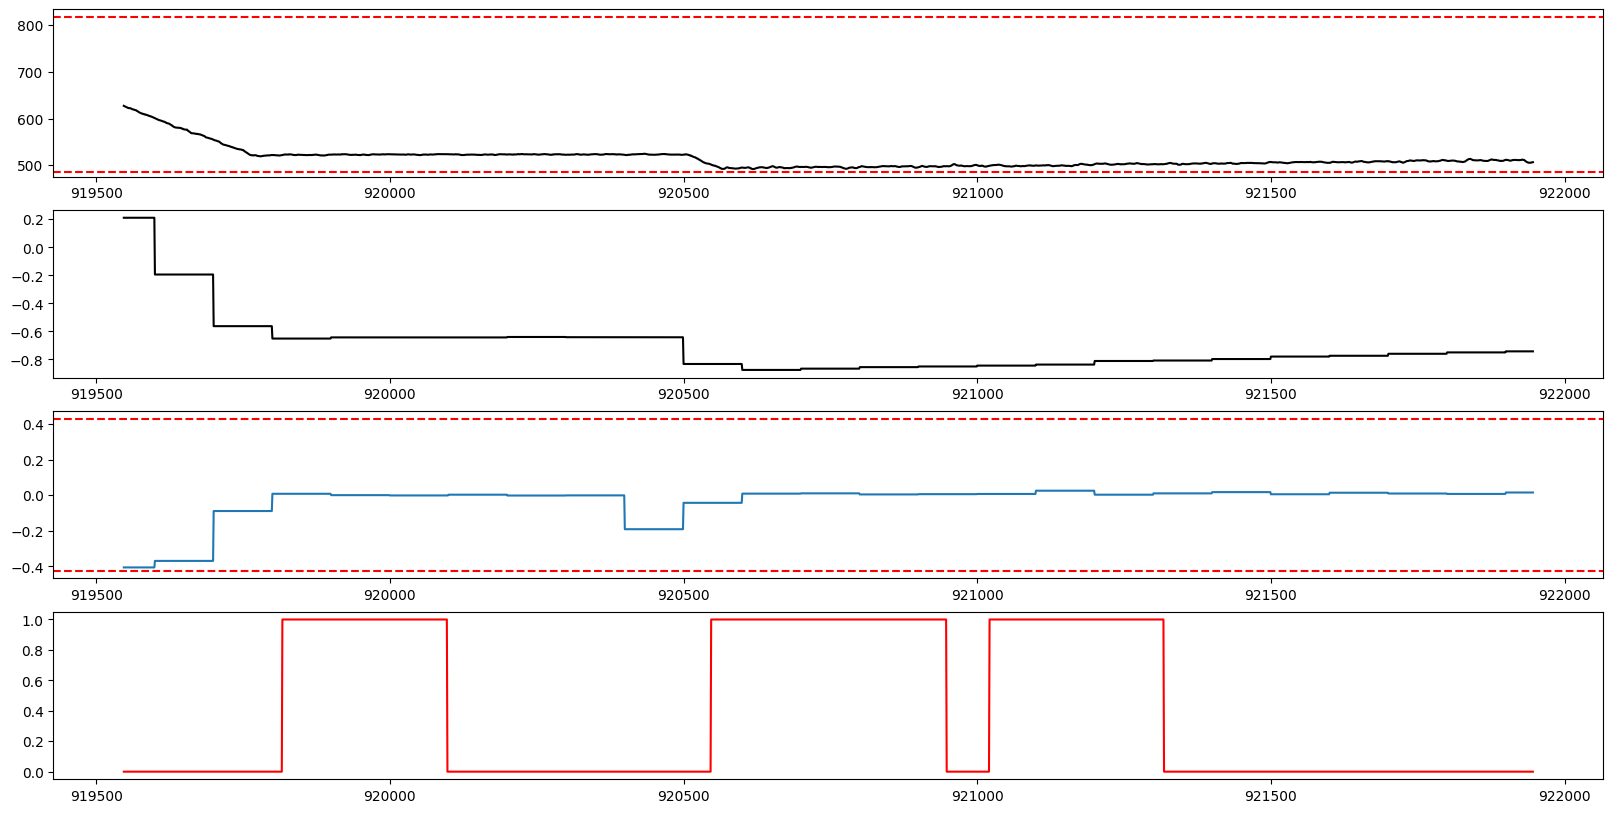

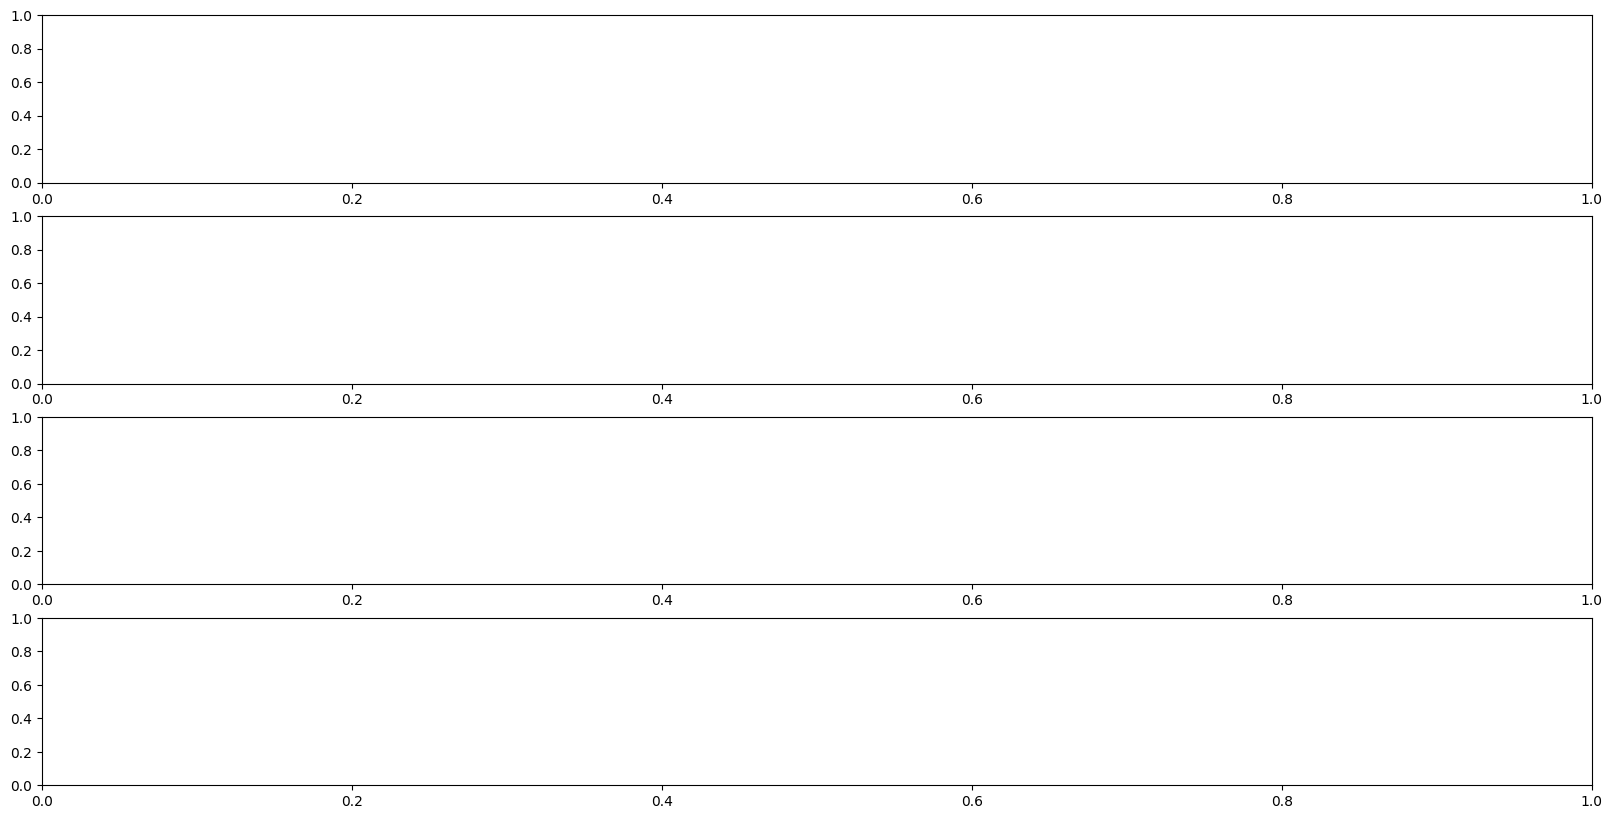

In [247]:
feature = 'LIT101'
for attack in get_index_attack(feature):
    
    fig, ax = plt.subplots(4, 1, figsize=(20, 10))

    index_min, index_max = get_timestamp_attack(index_attack=attack, offset=1000)
    ax[0].plot(df[feature].iloc[index_min:index_max], color='black')
    ax[0].axhline(y=np.max(train[feature]), color='red', linestyle='--')
    ax[0].axhline(y=np.min(train[feature]), color='red', linestyle='--')
    
    ax[1].plot(df[f'{feature}_median'].iloc[index_min:index_max], color='black')
    
    ax[2].plot(df[f'{feature}_median_slope'].iloc[index_min:index_max])
    quantiles = np.quantile(train[f'{feature}_median_slope'], [0.01, 0.99])
    ax[2].axhline(y=quantiles[0], color='red', linestyle='--')
    ax[2].axhline(y=quantiles[1], color='red', linestyle='--')
    # ax[2].axhline(y=np.max(train_copy['slope']), color='red', linestyle='--')
    # ax[2].axhline(y=np.min(train_copy['slope']), color='red', linestyle='--')
    
    ax[3].plot(df['Normal/Attack'].iloc[index_min:index_max], color='r')

In [300]:

def get_state(row, quantiles):
    # point = [i for i in range(quantiles)]
    for i, quantile in enumerate(quantiles):
        if row <= quantile:
            return i
        
    return len(quantiles) - 1

In [301]:
slope_cols = [col for col in df.columns if 'median_slope' in col]

In [302]:
for col in slope_cols:
    quantiles = np.quantile(train[col], [0.01, 0.99])
    discrete_col = col.replace('median_slope', '')
    df[discrete_col+'discrete'] = df[col].apply(lambda x: get_state(x, quantiles))

In [303]:
discrete_cols = []
for col in df.columns:
    if 'discrete' in col or col in cols_discrete:
        discrete_cols.append(col)

discrete_cols.remove('Normal/Attack')

In [756]:
train, test = get_train_test_dataset(df)

In [306]:
train_feature = train[discrete_cols]
test_feature = test[discrete_cols]

In [104]:
model_isf = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.001, max_features=train_feature.shape[1])
model_isf.fit(train_feature)

/Users/david/SWaT_Analysis_TFE/.env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.001, max_features=45)

Isolation Forest (baseline) model
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    410855
           1       0.60      0.87      0.71     37310

    accuracy                           0.94    448165
   macro avg       0.79      0.91      0.84    448165
weighted avg       0.96      0.94      0.95    448165

f1_score: 83.86%


/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_82044/1092890683.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_df = pd.DataFrame().append({'model_name':model_name,


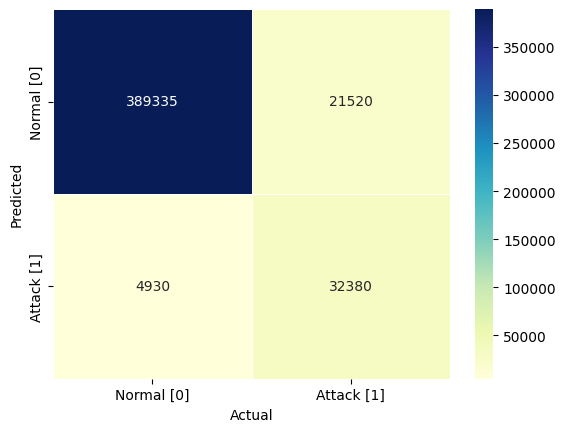

In [84]:

model_name = 'Isolation Forest (baseline)'
print(f'{model_name} model')

map_labels = True
model_score = measure_performance(model_isf, test_feature, y_test, map_labels)

performance_df = pd.DataFrame().append({'model_name':model_name, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)

n_estimators:100, c:0.1   = 44757 attacks   175000 normal 45 features
n_estimators:100, c:0.01  = 35153 attacks   19473  normal 45 features
n_estimators:100, c:0.001 = 33958 attacks   3476   normal 45 features

n_estimators:500, c:0.0000001 = 18000 attacks 289 normal 45 features
n_estimators:500, c:0.001 = 32387  attacks 4638 normal 45 features

n_estimators:300, c:0.1   = 42721 attacks 126000 normal


n_estimators:100, c:0.1   = 44757 attacks 175000 normal 45 features
n_estimators:100, c:0.1   = 43458 attacks 181000 normal 37 features

### Get State

In [106]:
discrete_cols = []
for col in df.columns:
    if 'slope' in col or col in cols_discrete:
        discrete_cols.append(col)

discrete_cols.remove('Normal/Attack')

In [307]:
df_state = df[discrete_cols]

In [308]:
df_state['Normal/Attack'] = df['Normal/Attack']
df_state['Timestamp'] = df['Timestamp']

/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_17351/985057770.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_state['Normal/Attack'] = df['Normal/Attack']
/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_17351/985057770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_state['Timestamp'] = df['Timestamp']


In [309]:
def set_sequence(row):
    sequence = str('')
    for value in row:
        sequence += str(value)
    return sequence

In [310]:
df_state['state'] = df_state[discrete_cols].apply(lambda row: set_sequence(row), axis=1)

/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_17351/1378822982.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_state['state'] = df_state[discrete_cols].apply(lambda row: set_sequence(row), axis=1)


In [311]:
df_state_train, df_state_test = get_train_test_dataset(df_state)

In [312]:
print('df_state_train states: ', len(df_state_train['state'].value_counts()))
print('df_state_test states: ', len(df_state_test['state'].value_counts()))
print('total df_state states: ', len(df_state['state'].value_counts()))
print('df_state state in common', (len(df_state_train['state'].value_counts())+len(df_state_test['state'].value_counts()))-len(df_state['state'].value_counts()))
print('percentage of common:', ((len(df_state_train['state'].value_counts())+len(df_state_test['state'].value_counts()))-len(df_state['state'].value_counts())) / len(df_state['state'].value_counts()))

df_state_train states:  1022
df_state_test states:  1558
total df_state states:  2221
df_state state in common 359
percentage of common: 0.16163890139576767


In [78]:
print('df_state_train states: ', len(df_state_train['state'].value_counts()))
print('df_state_test states: ', len(df_state_test['state'].value_counts()))
print('total df_state states: ', len(df_state['state'].value_counts()))
print('df_state state in common', (len(df_state_train['state'].value_counts())+len(df_state_test['state'].value_counts()))-len(df_state['state'].value_counts()))
print('percentage of common:', ((len(df_state_train['state'].value_counts())+len(df_state_test['state'].value_counts()))-len(df_state['state'].value_counts())) / len(df_state['state'].value_counts()))

df_state_train states:  1735
df_state_test states:  2481
total df_state states:  3988
df_state state in common 228
percentage of common: 0.05717151454363089


In [159]:
print('df_state_train states: ', len(df_state_train['state'].value_counts()))
print('df_state_test states: ', len(df_state_test['state'].value_counts()))
print('total df_state states: ', len(df_state['state'].value_counts()))
print('df_state state in common', (len(df_state_train['state'].value_counts())+len(df_state_test['state'].value_counts()))-len(df_state['state'].value_counts()))
print('percentage of common:', ((len(df_state_train['state'].value_counts())+len(df_state_test['state'].value_counts()))-len(df_state['state'].value_counts())) / len(df_state['state'].value_counts()))

df_state_train states:  1719
df_state_test states:  2379
total df_state states:  3860
df_state state in common 238
percentage of common: 0.061658031088082904


In [317]:
count_states = pd.DataFrame(columns=['state', 'time'])
list_of_states = []

for i in range(len(df_state_train)):
    if df_state_train['state'].iloc[i] not in list_of_states:
        count_states = pd.concat(objs=[count_states, pd.DataFrame({'state': df_state_train['state'].iloc[i], 'time': [df_state_train['Timestamp'].iloc[i]]})], axis=0)
        list_of_states.append(df_state_train['state'].iloc[i])

count_states = count_states.reset_index(drop=True)
count_states['count_state'] = count_states.index

In [318]:
df_count_states = pd.merge(df_state_train, count_states, on='state', how='right')

<AxesSubplot:xlabel='time', ylabel='count_state'>

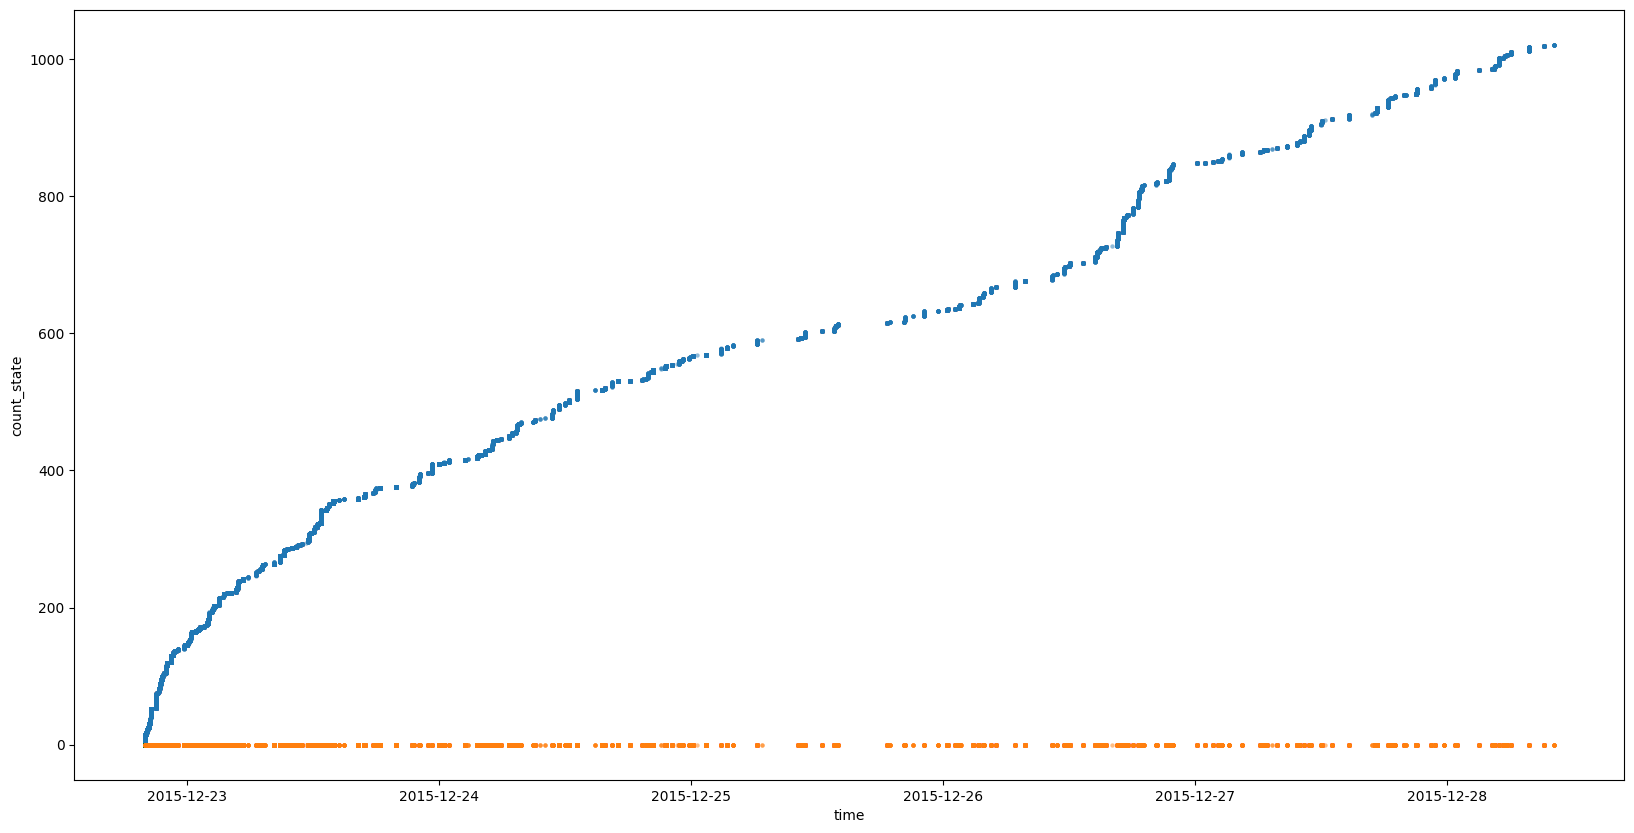

In [319]:
# count_states.plot(x='time', y='index', kind='scatter')
ax, fig = plt.subplots(figsize=(20, 10))
sns.scatterplot(x='time', y='count_state', data=df_count_states.reset_index(drop=True), s=10, alpha=0.5, marker='o', linewidth=0)

<AxesSubplot:xlabel='time', ylabel='count_state'>

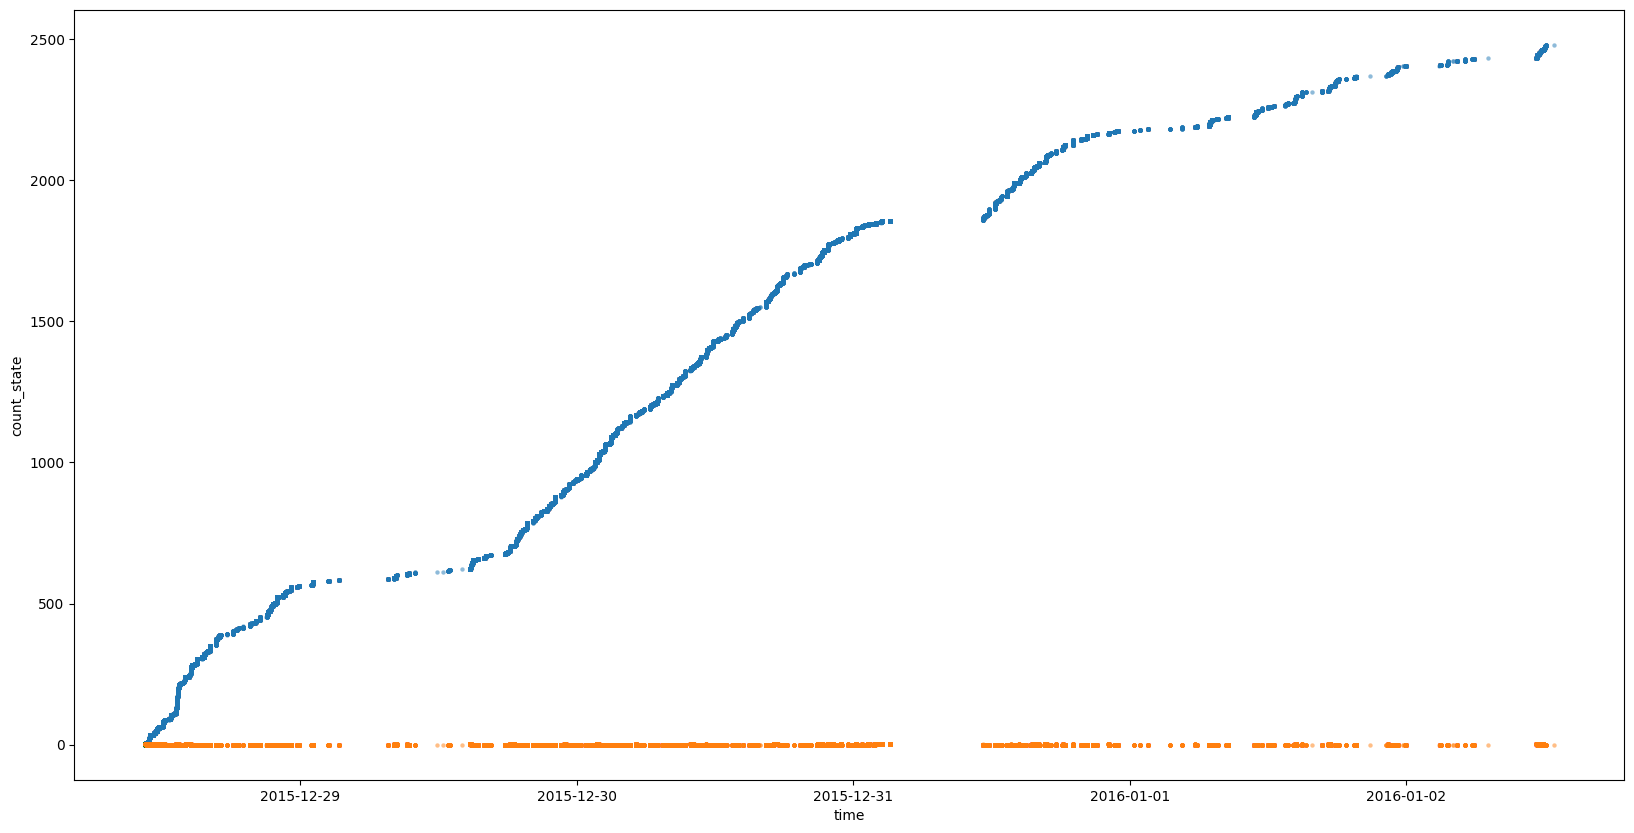

In [81]:
# count_states.plot(x='time', y='index', kind='scatter')
ax, fig = plt.subplots(figsize=(20, 10))
sns.scatterplot(x='time', y='count_state', data=df_count_states.reset_index(drop=True), s=10, alpha=0.5, marker='o', linewidth=0)
sns.scatterplot(x='time', y='Normal/Attack', data=df_count_states.reset_index(drop=True), s=10, alpha=0.5, marker='o', linewidth=0)


<AxesSubplot:xlabel='time', ylabel='count_state'>

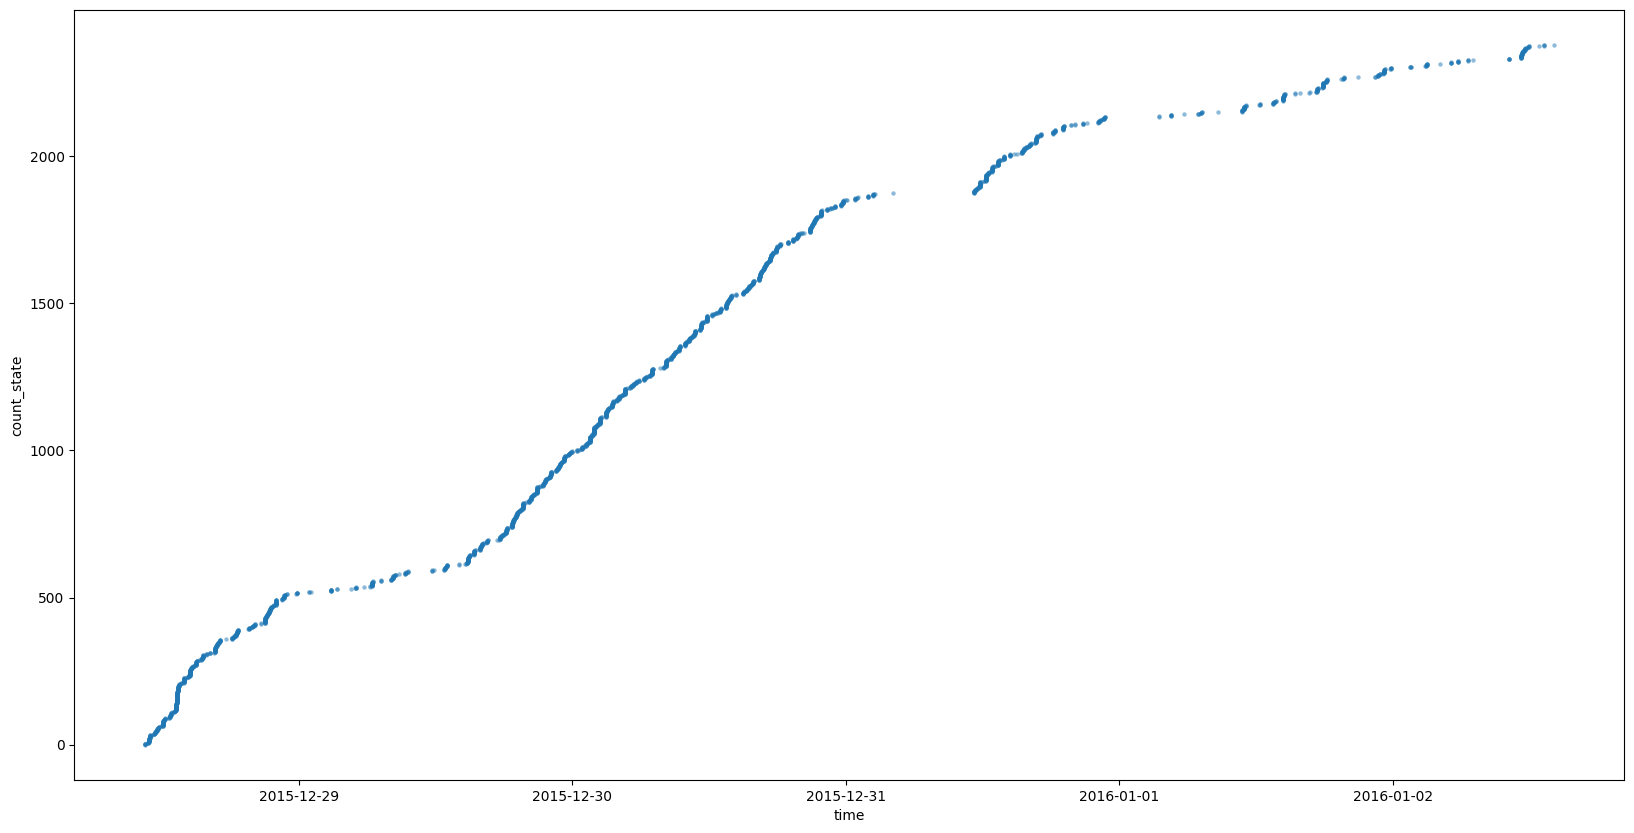

In [163]:
# count_states.plot(x='time', y='index', kind='scatter')
ax, fig = plt.subplots(figsize=(20, 10))
sns.scatterplot(x='time', y='count_state', data=count_states, s=10, alpha=0.5, marker='o', linewidth=0)


In [320]:
known_state_attack = df_state[df_state['Normal/Attack'] == 1]['state'].unique()
len(known_state_attack)

379

In [84]:
df_state['Normal/Attack'].value_counts()

0    878419
1     53900
Name: Normal/Attack, dtype: int64

In [321]:
attack_state = pd.DataFrame(columns=['state', 'cnt_attack', 'cnt_normal'])

for state in known_state_attack:
    state_cnt = df_state[df_state['state'] == state]
    df_state_runner = pd.DataFrame({
        'state': [state], 
        'cnt_attack': len(state_cnt[state_cnt['Normal/Attack'] == 1]),
        'cnt_normal': len(state_cnt[state_cnt['Normal/Attack'] == 0])
    })
    attack_state = pd.concat(objs=[attack_state, df_state_runner], axis=0)
    

In [87]:
known_state = df_state['state'].unique()
len(known_state)

3988

In [88]:
not_attack_state = pd.DataFrame(columns=['state', 'cnt_attack', 'cnt_normal'])

for state in known_state:
    state_cnt = df_state[df_state['state'] == state]
    df_state_runner = pd.DataFrame({
        'state': [state], 
        'cnt_attack': len(state_cnt[state_cnt['Normal/Attack'] == 1]),
        'cnt_normal': len(state_cnt[state_cnt['Normal/Attack'] == 0])
    })
    not_attack_state = pd.concat(objs=[not_attack_state, df_state_runner], axis=0)
    

In [89]:
not_attack_state.sort_values(by='cnt_attack', ascending=False)

,state,cnt_attack,cnt_normal
0,111111111111211111111010110111100011100000000,29127,0
0,111111111111211111111010100111100011100000000,2600,0
0,221212121121112212210100101111011001111111010,1528,9867
0,111111111111211212211010100111010000111111010,1456,0
0,221212121121112212211100101111011001111111010,919,32992
...,...,...,...
0,111111111111212212211011000111010101011111010,0,263
0,111111111101212212211011000111010101011111010,0,69
0,111111111121212212211011000111010101011111010,0,19
0,111111111121012212211011000111010101011111010,0,66


In [325]:
know_state = df_state_train['state'].unique()
attack_state = df_state_test['state'].unique()
common_state = np.intersect1d(know_state, attack_state)
not_common_state = np.setdiff1d(attack_state, know_state)

In [326]:
count = 0
count_normal = 0
for state in common_state:
    count += len(df_state_test[(df_state_test['state'] == state) & (df_state_test['Normal/Attack'] == 1)])
    count_normal += len(df_state_test[(df_state_test['state'] == state) & (df_state_test['Normal/Attack'] == 0)])
print('common state with an attack in test', count, '\ncommon state without an attack in test',count_normal)

common state with an attack in test 10890 
common state without an attack in test 307262


Faux Positive : predict Attack but NOT an attack


In [327]:
count = 0
count_normal = 0
for state in not_common_state:
    count += len(df_state_test[(df_state_test['state'] == state) & (df_state_test['Normal/Attack'] == 1)])
    count_normal += len(df_state_test[(df_state_test['state'] == state) & (df_state_test['Normal/Attack'] == 0)])
print('not common state with an attack in test', count, '\nnot common state without an attack in test',count_normal)

not common state with an attack in test 43010 
not common state without an attack in test 87003


# Multi Model Checking

## Detect cycle in feature

Process-aware ML Based Intrusion Detection for Industrial Control Systems

In [181]:
data = df[cols_numeric]
min_max_normalized_df = (data-data.min())/(data.max()-data.min())

In [185]:
min_max_normalized_df['Timestamp'] = df['Timestamp']

In [186]:
train_norm, test_norm = get_train_test_dataset(min_max_normalized_df)

In [13]:
train, test = get_train_test_dataset(df)

In [5]:
def get_delay_embedding(col, TAU):
    time_series = train[col]

    # windowSize = 30
    # time_series = time_series - time_series.rolling(windowSize, center=True).mean()
    # time_series = time_series.dropna()

    delay_coordinates = [  
                time_series[0 * TAU:len(time_series) - TAU * 1], # t
                time_series[1 * TAU:len(time_series) - TAU * 0], # t-T
            ]
    
    
    return delay_coordinates

In [68]:
TAU = 1100

for col in cols_continuous:
    list_corr = []
    for TAU in range(1, 10000, 1000):
        delay_coordinates = get_delay_embedding(col, TAU)
        corr = np.corrcoef([delay_coordinates[0], delay_coordinates[1]])[0, 1]
        list_corr.append(corr)
        
    print(col, 1 - np.mean(list_corr))
    # delay_coordinates = get_delay_embedding(col, TAU)
    # # print(col)
    # # print(delay_coordinates[0][0:10])
    # # print(delay_coordinates[1][0:10])
    # print(col, np.corrcoef([delay_coordinates[0], delay_coordinates[1]])[0, 1])

FIT101 0.9141043488636664
LIT101 0.9071088405375942
AIT201 0.018500252355347913
AIT202 0.7636557140188214
AIT203 0.0897049413366936
FIT201 0.9187658576138078
DPIT301 0.9275874922979827
FIT301 0.9258230774171945
LIT301 0.9050523861806088
AIT401 0.03926327906470617
AIT402 0.005796016418889716
FIT401 0.08966836807643586
LIT401 0.9146650034523339
AIT501 0.02539358104461864
AIT502 0.005999323718379523
AIT503 0.15598430438986932
AIT504 0.05285553705415591
FIT501 0.0784111128693592
FIT502 0.40805493551107763
FIT503 0.06631373370491289
FIT504 0.23104533221719503
PIT501 0.054406098942972214
PIT502 0.16757798927264278
PIT503 0.047993425670694534
FIT601 0.9074607289046901


In [122]:
col = 'AIT202'
list_corr = []
for LAG in range(1, 100000, 100):
    delay_coordinates = get_delay_embedding(f'{col}', LAG)
    corr = np.corrcoef([delay_coordinates[0], delay_coordinates[1]])[0, 1]
    list_corr.append(corr)
    
corr_df_AIT202 = pd.DataFrame(list_corr, columns=['corr'])
corr_df_AIT202['lag'] = (corr_df_AIT202.index + 1) * 1000


In [145]:
index = []
previous_corr = corr_df['corr'][0]
for i in range(1, len(corr_df['corr'])):
    corr = corr_df['corr'][i]
    if corr < 0 and previous_corr > 0:
        index.append(i)
    if corr > 0 and previous_corr < 0:
        index.append(i)
    previous_corr = corr

df_index = pd.DataFrame(index, columns=['index'])

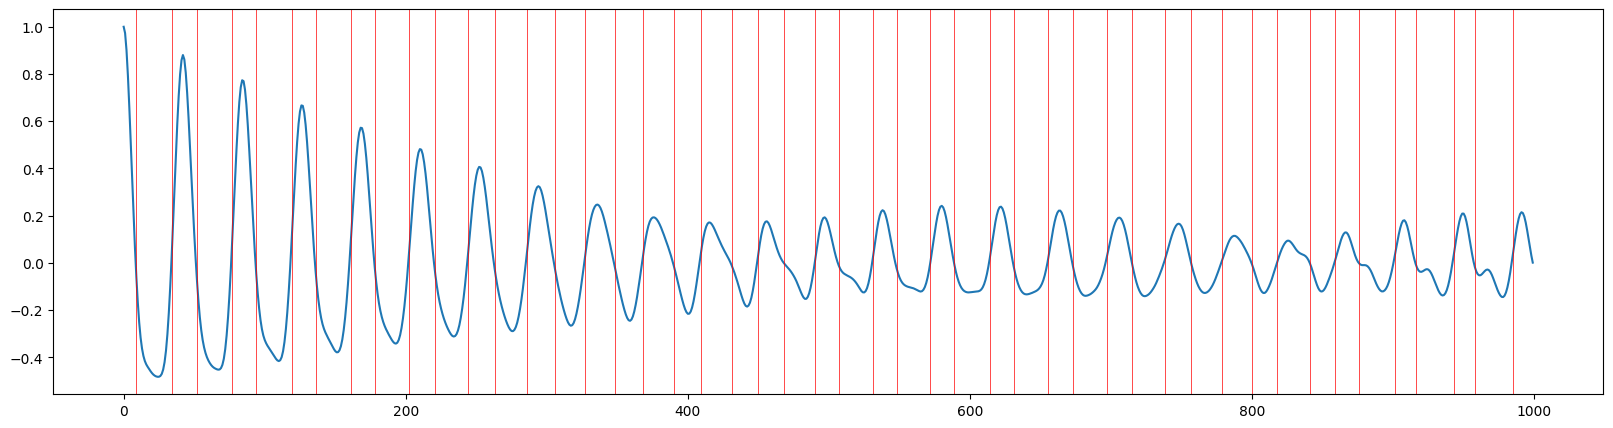

In [146]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(corr_df['corr'])
for i in range(len(df_index)):
    plt.axvline(x=df_index['index'][i], color='r', linestyle='-', linewidth=0.5)

In [7]:
len(cols_continuous)

25

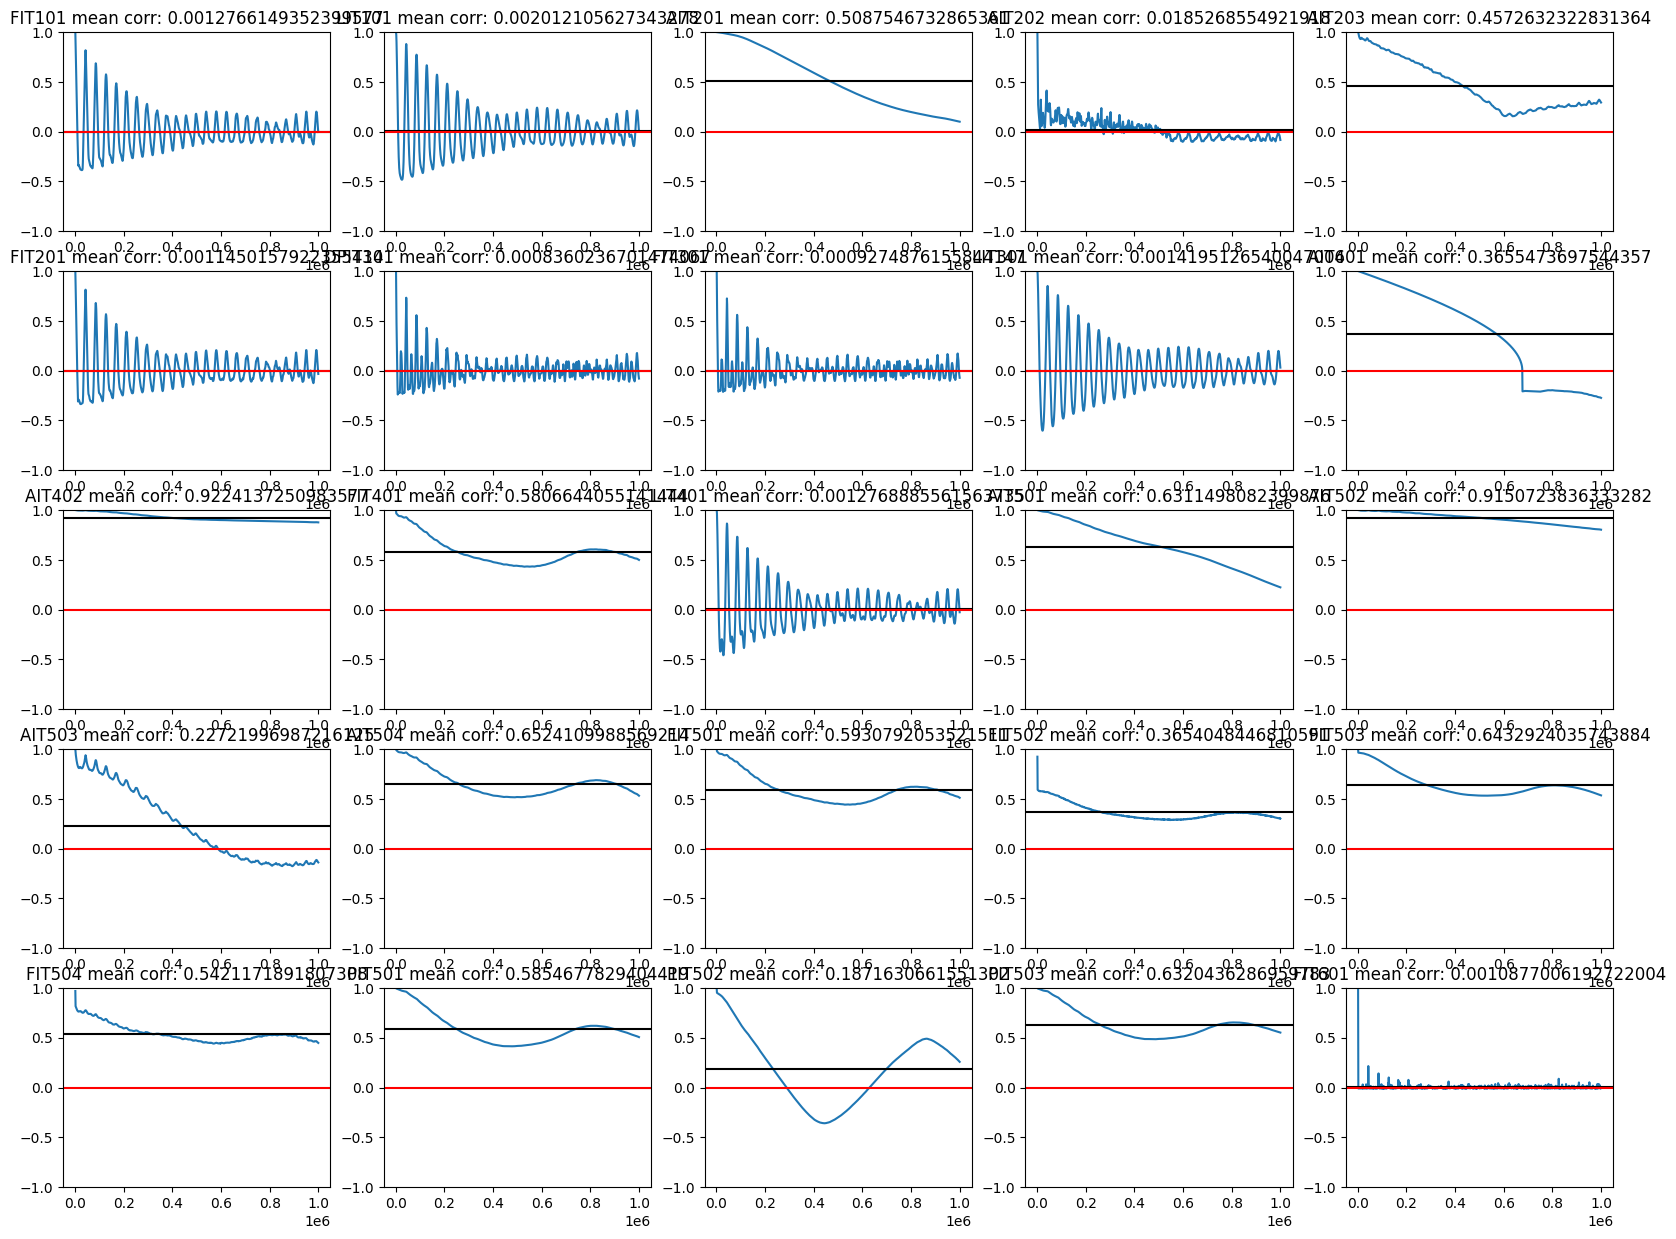

In [10]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))

for i, col in enumerate(cols_continuous):
    
    list_corr = []
    for LAG in range(1, 100000, 100):
        delay_coordinates = get_delay_embedding(f'{col}', LAG)
        corr = np.corrcoef([delay_coordinates[0], delay_coordinates[1]])[0, 1]
        list_corr.append(corr)
    
    corr_df = pd.DataFrame(list_corr, columns=['corr'])
    corr_df['lag'] = (corr_df.index + 1) * 1000
    
    # fig, ax = plt.subplots(figsize=(20, 5))
    ax[i // 5, i % 5].plot(corr_df['lag'], corr_df['corr'])
    ax[i // 5, i % 5].axhline(y=np.mean(corr_df['corr']), color='black', linestyle='-')
    ax[i // 5, i % 5].axhline(y=0, color='r', linestyle='-')
    ax[i // 5, i % 5].set_ylim(-1, 1)
    ax[i // 5, i % 5].set_title(f'{col} mean corr: {np.round(np.mean(corr_df["corr"]), 2)}')
    # plt.show()

<AxesSubplot:>

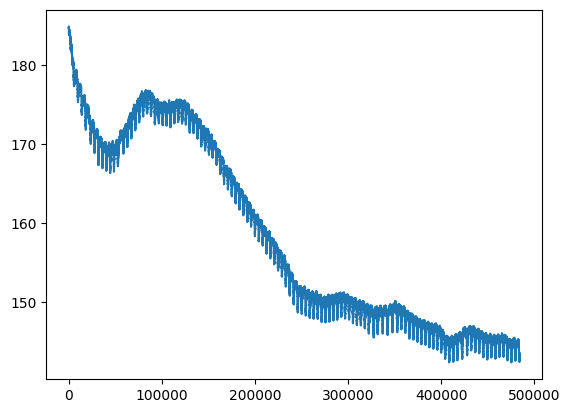

In [148]:
train['AIT502'].plot()

In [14]:
df

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P402,P403,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,PIT501,PIT502,PIT503,FIT601,P602,Normal/Attack,index,attack,FIT101_discrete,LIT101_discrete,AIT201_discrete,AIT202_discrete,AIT203_discrete,FIT201_discrete,DPIT301_discrete,FIT301_discrete,LIT301_discrete,AIT401_discrete,AIT402_discrete,FIT401_discrete,LIT401_discrete,AIT501_discrete,AIT502_discrete,AIT503_discrete,AIT504_discrete,FIT501_discrete,FIT502_discrete,FIT503_discrete,FIT504_discrete,PIT501_discrete,PIT502_discrete,PIT503_discrete,FIT601_discrete,LIT301_median,FIT101_median,LIT101_median,AIT201_median,AIT202_median,AIT203_median,FIT201_median,DPIT301_median,FIT301_median,AIT401_median,AIT402_median,FIT401_median,LIT401_median,AIT501_median,AIT502_median,AIT503_median,AIT504_median,FIT501_median,FIT502_median,FIT503_median,FIT504_median,PIT501_median,PIT502_median,PIT503_median,FIT601_median,LIT301_median_slope,FIT101_median_slope,LIT101_median_slope,AIT201_median_slope,AIT202_median_slope,AIT203_median_slope,FIT201_median_slope,DPIT301_median_slope,FIT301_median_slope,AIT401_median_slope,AIT402_median_slope,FIT401_median_slope,LIT401_median_slope,AIT501_median_slope,AIT502_median_slope,AIT503_median_slope,AIT504_median_slope,FIT501_median_slope,FIT502_median_slope,FIT503_median_slope,FIT504_median_slope,PIT501_median_slope,PIT502_median_slope,PIT503_median_slope,FIT601_median_slope,state
0,2015-12-22 20:00:00,2.455882,643.3135,2,2,1,262.2404,8.381056,442.6301,2.470509,2,1,2,1,1,1,0.044817,0.000000,895.3234,2,1,2,1,1,1,0.0000,197.4878,1.701855,850.6665,2,1,2,7.861638,184.6193,269.7065,11.95847,1.712125,1.281158,0.739110,0.308426,2,253.3645,1.329574,192.5628,1.696537,2,0,14400,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.112583,0.663031,0.368082,0.666705,-0.603465,2.871779,0.642121,-1.826804,-1.593908,-3.578742,0.962786,0.161796,-0.208457,0.404178,1.753029,0.628115,-0.207063,0.157194,0.133817,0.220851,0.216611,0.243814,0.695564,0.269828,-0.098210,0.305046,0.002608,0.013393,0.002644,0.023479,-0.123325,0.000175,2.025139,1.897091,0.0,-0.011081,-0.005847,-0.210816,-0.02115,-0.021374,0.005383,0.0,-0.003465,-0.003,0.0,-0.00668,-0.003992,0.146378,-0.004933,-0.000834,221212111212111212221111111111111111111111111
1,2015-12-22 20:00:01,2.431861,643.6667,2,2,1,262.2404,8.381056,442.5019,2.470509,2,1,2,1,1,1,0.044817,0.000000,895.9241,2,1,2,1,1,1,0.0000,197.4878,1.701855,850.0128,2,1,2,7.861638,184.6193,269.7065,11.95847,1.711484,1.282567,0.739110,0.308426,2,253.3004,1.329574,192.5628,1.723064,2,0,14401,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.112583,0.663031,0.368082,0.666705,-0.603465,2.871779,0.642121,-1.826804,-1.593908,-3.578742,0.962786,0.161796,-0.208457,0.404178,1.753029,0.628115,-0.207063,0.157194,0.133817,0.220851,0.216611,0.243814,0.695564,0.269828,-0.098210,0.305046,0.002608,0.013393,0.002644,0.023479,-0.123325,0.000175,2.025139,1.897091,0.0,-0.011081,-0.005847,-0.210816,-0.02115,-0.021374,0.005383,0.0,-0.003465,-0.003,0.0,-0.00668,-0.003992,0.146378,-0.004933,-0.000834,221212111212111212221111111111111111111111111
2,2015-12-22 20:00:02,2.425135,643.6667,2,2,1,262.2404,8.381056,442.5019,2.470509,2,1,2,1,1,1,0.044817,0.000000,896.0443,2,1,2,1,1,1,0.0000,197.4878,1.701855,850.2051,2,1,2,7.861638,184.6193,269.7065,11.95847,1.711484,1.282567,0.739110,0.308426,2,253.2844,1.329574,192.5628,1.729536,2,0,14402,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.112583,0.663031,0.368082,0.666705,-0.603465,2.871779,0.642121,-1.826804,-1.593908,-3.578742,0.962786,0.161796,-0.208457,0.404178,1.753029,0.628115,-0.207063,0.157194,0.133817,0.220851,0.216611,0.243814,0.695564,0.269828,-0.098210,0.305046,0.002608,0.013393,0.002644,0.023479,-0.123325,0.000175,2.025139,1.897091,0.0,-0.011081,-0.005847,-0.210816,-0.02115,-0.021374,0.005383,0.0,-0.003465,-0.00

## Sliding Median

<AxesSubplot:>

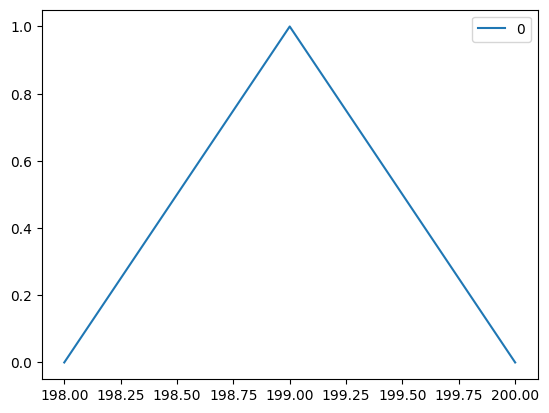

In [50]:
arr.iloc[198:201].plot()

In [64]:
arr = pd.DataFrame(np.diff(df[f'{col}_median']) >= 0).astype(dtype='int')

In [68]:
for i in range(99, len(arr), 100):
    ar = df[f'{col}_median'].iloc[i]
    print(ar)

0.36808238332203025
0.38147504311509933
0.38653827404034646
0.39682742167371227
0.4046662967358912
0.4103827672496534
0.4237750109665511
0.4412502101497522
0.45954299900902496
0.7157939108412661
1.098619354662119
1.5510193914976909
1.769706530533299
1.7674197758973258
1.6140615886272607
1.2064113761381572
0.8083966556177339
0.3749422311537791
-0.01866249802991167
-0.403121040822052
-0.82057026321505
-0.8911247156125415
-0.8829588046799338
-0.8689129052983505
-0.8568275568346537
-0.8514381221913199
-0.839842495380924
-0.8310225127074594
-0.8135477296004292
-0.802605342378548
-0.8006447914606614
-0.779576358464457
-0.7763101605218821
-0.7692876269072614
-0.753934832272477
-0.7464225770045554
-0.7359694953598042
-0.7196376734945895
-0.7124516219447543
-0.4274556717608306
-0.016539261329153055
0.3679196975391582
0.806600870863575
1.1953054709810615
1.5142715440724441
1.5335441923144892
1.5415465853118826
1.5495498104616177
1.5619613626434008
1.5704547255226076
1.58580668800505
1.5846637267

In [92]:

def get_up_down(df, col, sign):
    arr = pd.DataFrame(sign * np.diff(df[f'{col}_median']) >= sign * -0.05).astype(dtype='int')

    up_down = []
    accumulator = 0
    for i in range(99, len(arr), 100):
        ar = arr.iloc[i].values
        accumulator = 0 if ar == 0 else accumulator + 1
        up_down.append(accumulator)
    
    return pd.DataFrame(up_down, columns=['up_down'])

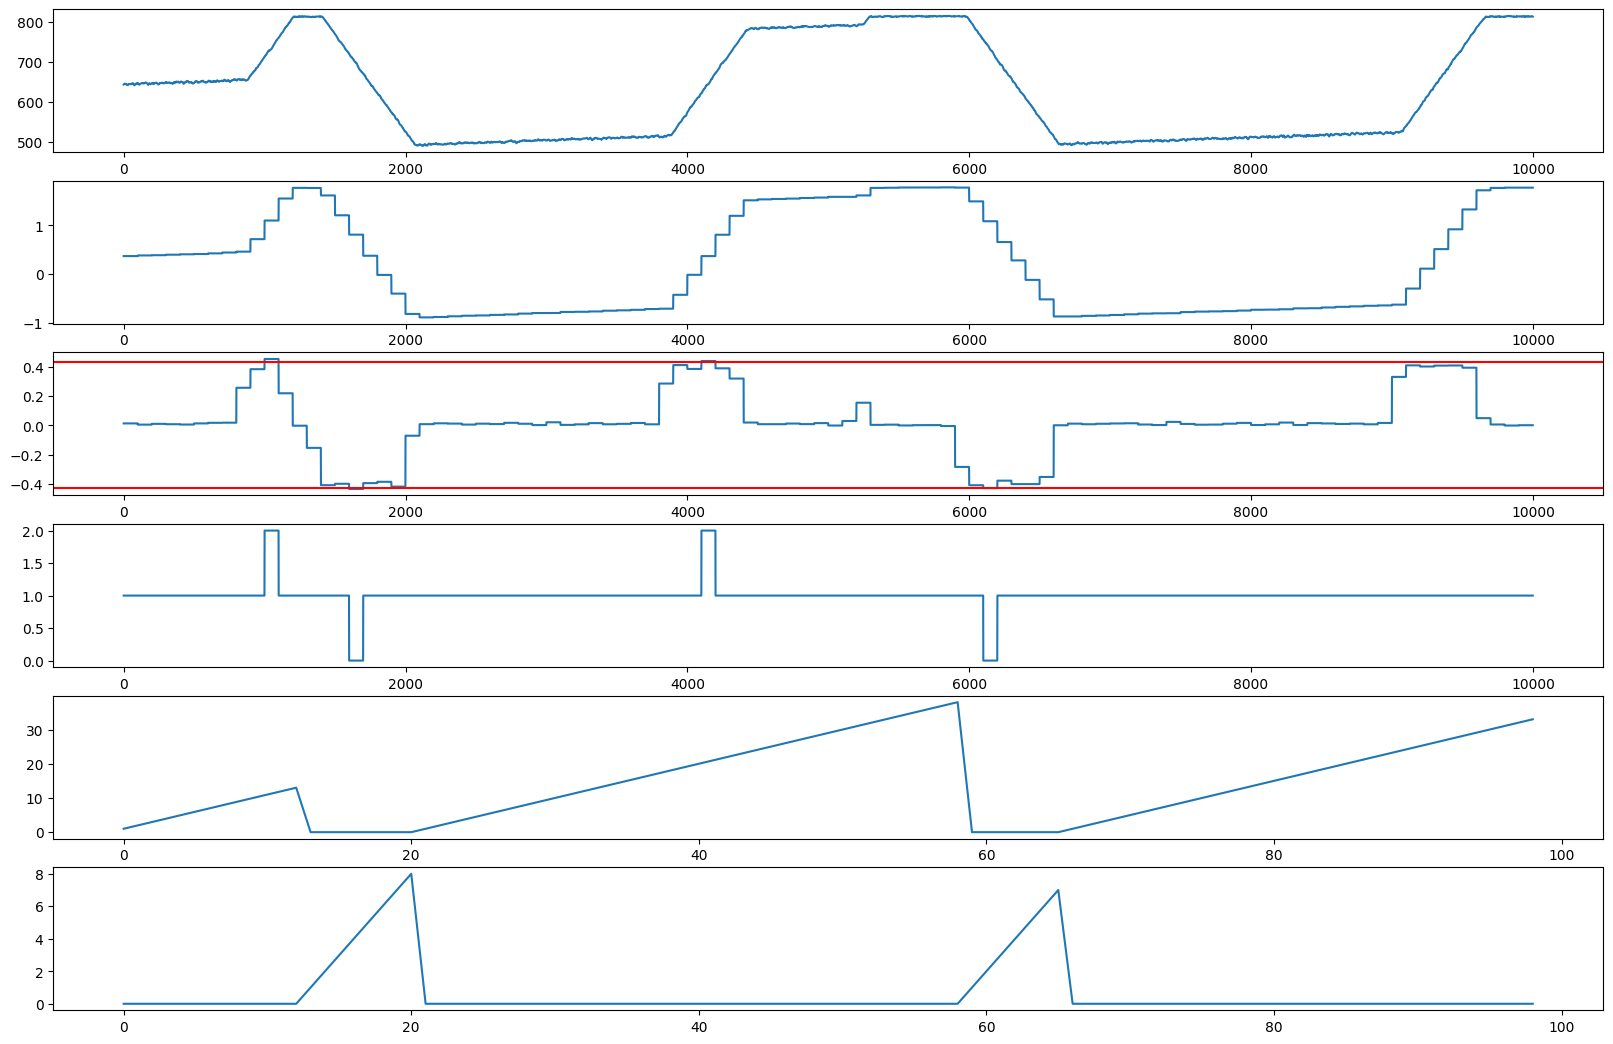

In [93]:
fig, ax = plt.subplots(6, 1, figsize=(20, 13))

col = 'LIT101'

data = df.iloc[000:10000]

quantile99 = np.quantile(train[f'{col}_median_slope'], 0.99)
quantile01 = np.quantile(train[f'{col}_median_slope'], 0.01)
df_state = data[f'{col}_median_slope'].apply(lambda x: 2 if x > quantile99 else (0 if x < quantile01 else 1))

ax[0].plot(data[col])

ax[1].plot(data[f'{col}_median'])

ax[2].plot(data[f'{col}_median_slope'])
ax[2].axhline(y=quantile01, color='r', linestyle='-')
ax[2].axhline(y=quantile99, color='r', linestyle='-')

ax[3].plot(df_state)

arr = pd.DataFrame(np.diff(data[f'{col}_median']) > 0).astype(dtype='int')
# ax[4].plot(arr)
up = get_up_down(data, col, 1)
ax[4].plot(up)
down = get_up_down(data, col, -1)
ax[5].plot(down)



In [178]:
col = 'LIT101'
window_size = 30

df_copy = df[col].copy()

slope_feature = [0] * 1 + [ x for x in np.diff(np.array(df_copy))]#1 if x > 0 else -1 for

slope_x = pd.DataFrame(slope_feature, columns=['slope'])

slope_adjusted = []
for i in range(0, 120):#len(slope_feature)-window_size, n):
    a = window_size
    if i+window_size > len(slope_feature):
        a = len(slope_feature) - i
        slope_adjusted += [slope_feature[i+a-1]]
    else:
        slope_adjusted += [slope_feature[i+a]]

df_adjusted =  pd.DataFrame(slope_adjusted)
df_adjusted

,0
0,0.0785
1,0.3140
2,-0.1570
3,0.0000
4,0.2748
...,...
115,-0.3532
116,-0.0393
117,0.0000
118,-0.1963


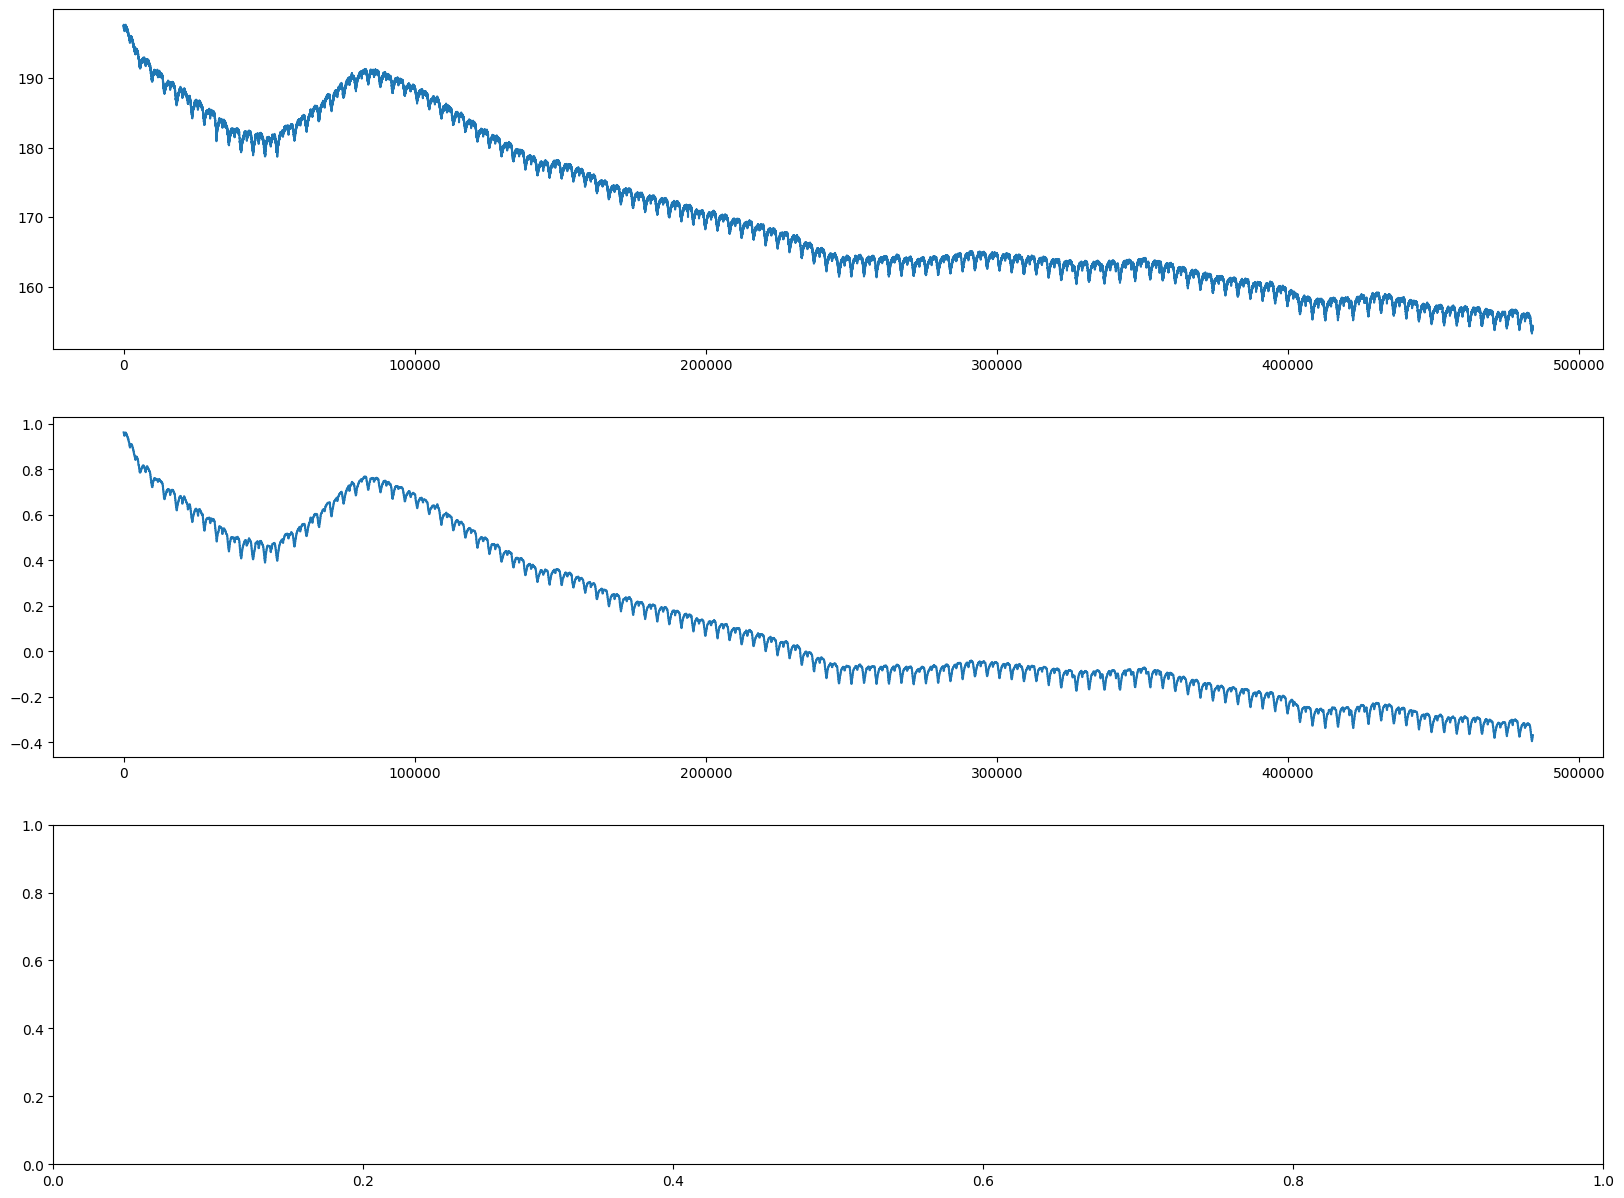

In [52]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
ax[0].plot(train['AIT402'])
ax[1].plot(train['AIT402_median'])

In [5]:
df_cols = pd.read_pickle('dataset/train_dataset.pkl')

cols_numeric = list(df_cols.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('index')
cols_numeric.remove('attack')
cols_numeric.remove('Normal/Attack')

cols_continuous = []
for col in cols_numeric:
    if len(df_cols[col].unique()) > 5:
        cols_continuous.append(col)

## Checking Algorithm Model

In [18]:
train, test = get_train_test_dataset(df)

### Get the min max value on continuous feature

In [7]:
model_continuous_feature_check = pd.DataFrame(columns=['col', 'min', 'max'])

for col in cols_continuous:
    col_df = pd.DataFrame({
        'col': [col],
        'min': [train[col].min()],
        'max': [train[col].max()]
    })
    model_continuous_feature_check = pd.concat(objs=[model_continuous_feature_check, col_df], axis=0, ignore_index=True)

In [35]:
col = 'AIT201'
np.var(df[col].iloc[0:30])

3.2311742677852644e-27

In [158]:
data = df[cols_numeric]
data_cor = data.corr()
# Set the threshold and add to pairs to list
t = 0.95
cor_list = []

#Find Pairs and update cor_list
for i in range(0,len(data.columns)):
    for j in range(i+1,len(data.columns)):
        correlation = data_cor.iloc[i,j] #Find correlation between two columns
        if correlation >= t or correlation <= -t:
            cor_list.append([data_cor.iloc[i,j],i,j])

#Sort by corr coef
sorted_list = sorted(cor_list,key=lambda x: -abs(x[0]))

for v,i,j in sorted_list:
    print ("%s and %s = %.5f" % (data.columns[i],data.columns[j],v))

UV401 and P501 = 0.99991
PIT501 and PIT503 = 0.99967
FIT503 and PIT501 = 0.99826
FIT501 and FIT502 = 0.99749
FIT503 and PIT503 = 0.99674
P402 and FIT501 = 0.99668
FIT501 and FIT503 = 0.99568
FIT201 and P203 = 0.99526
FIT501 and PIT501 = 0.99460
P402 and PIT501 = 0.99403
FIT503 and FIT504 = 0.99400
P402 and PIT503 = 0.99378
P402 and FIT502 = 0.99367
FIT501 and PIT503 = 0.99285
FIT503 and P501 = 0.99250
UV401 and FIT503 = 0.99244
P101 and P203 = 0.99171
P101 and FIT201 = 0.99163
FIT504 and P501 = 0.99162
UV401 and FIT504 = 0.99156
FIT502 and FIT503 = 0.99120
P204 and P206 = 0.99103
P402 and FIT503 = 0.99088
FIT401 and P501 = 0.99084
FIT401 and UV401 = 0.99083
FIT401 and FIT503 = 0.98967
FIT502 and PIT501 = 0.98961
FIT401 and FIT501 = 0.98904
FIT501 and P501 = 0.98801
P501 and PIT501 = 0.98796
UV401 and FIT501 = 0.98795
UV401 and PIT501 = 0.98789
FIT401 and FIT502 = 0.98752
FIT502 and PIT503 = 0.98747
P101 and MV201 = 0.98743
FIT502 and P501 = 0.98731
UV401 and FIT502 = 0.98723
FIT504 and

In [140]:

index_group = 1
for index, (v,i,j) in enumerate(sorted_list):
    if data.columns[i] in cols_continuous or data.columns[j] in cols_continuous:
        print(index, data.columns[i], data.columns[j], v)

1 PIT501 PIT503 0.999674635289138
2 FIT503 PIT501 0.9982573992536415
3 FIT501 FIT502 0.9974891545680731
4 FIT503 PIT503 0.9967407613442671
5 P402 FIT501 0.9966807336629927
6 FIT501 FIT503 0.9956763980818522
7 FIT201 P203 0.9952625632207256
8 FIT501 PIT501 0.9946030417663101
9 P402 PIT501 0.9940329051147114
10 FIT503 FIT504 0.9940001828665846
11 P402 PIT503 0.993784124926807
12 P402 FIT502 0.9936705820661833
13 FIT501 PIT503 0.9928464105198522
14 FIT503 P501 0.9925044898398762
15 UV401 FIT503 0.9924418000786907
17 P101 FIT201 0.991627980750499
18 FIT504 P501 0.9916242610363831
19 UV401 FIT504 0.9915623731605574
20 FIT502 FIT503 0.9911991125577753
22 P402 FIT503 0.9908813627381382
23 FIT401 P501 0.990836715084958
24 FIT401 UV401 0.9908327055004117
25 FIT401 FIT503 0.98966624765201
26 FIT502 PIT501 0.9896070495649546
27 FIT401 FIT501 0.9890365881031958
28 FIT501 P501 0.9880117166965396
29 P501 PIT501 0.9879590779340709
30 UV401 FIT501 0.9879467358081965
31 UV401 PIT501 0.9878941578307723


In [126]:
index_group = 0
start_index = 0
end_index = len(train) 
coef = np.corrcoef(np.array(df[data.columns[sorted_list[index_group][1]]].iloc[start_index:end_index]), np.array(df[data.columns[sorted_list[index_group][2]]].iloc[start_index:end_index]))[0, 1]
coef = 1 if np.isnan(coef) else coef

In [9]:
# check if the actual row at time t is in the good range for each of continuous feature

def checking_min_max(row):
    col_anomaly = []
    for col in cols_continuous:
        if row[col] < model_continuous_feature_check[model_continuous_feature_check['col'] == col]['min'].values[0] or row[col] > model_continuous_feature_check[model_continuous_feature_check['col'] == col]['max'].values[0]:
            col_anomaly.append(col)
    if len(col_anomaly) > 0:
        return 1, col_anomaly
    return 0, col_anomaly

### Algorithm to get the maximum sequence of same value for each feature

In [14]:
df_median_cols = [col for col in df.columns if '_median_slope' in col]

In [19]:
train[df_median_cols]

,LIT301_median_slope,FIT101_median_slope,LIT101_median_slope,AIT201_median_slope,AIT202_median_slope,AIT203_median_slope,FIT201_median_slope,DPIT301_median_slope,FIT301_median_slope,AIT401_median_slope,AIT402_median_slope,FIT401_median_slope,LIT401_median_slope,AIT501_median_slope,AIT502_median_slope,AIT503_median_slope,AIT504_median_slope,FIT501_median_slope,FIT502_median_slope,FIT503_median_slope,FIT504_median_slope,PIT501_median_slope,PIT502_median_slope,PIT503_median_slope,FIT601_median_slope
0,0.305046,0.002608,0.013393,0.002644,0.023479,-0.123325,0.000175,2.025139,1.897091,0.0,-0.011081,-0.005847,-0.210816,-0.021150,-0.021374,0.005383,0.000000,-0.003465,-0.003000,0.000000,-0.00668,-0.003992,0.146378,-0.004933,-0.000834
1,0.305046,0.002608,0.013393,0.002644,0.023479,-0.123325,0.000175,2.025139,1.897091,0.0,-0.011081,-0.005847,-0.210816,-0.021150,-0.021374,0.005383,0.000000,-0.003465,-0.003000,0.000000,-0.00668,-0.003992,0.146378,-0.004933,-0.000834
2,0.305046,0.002608,0.013393,0.002644,0.023479,-0.123325,0.000175,2.025139,1.897091,0.0,-0.011081,-0.005847,-0.210816,-0.021150,-0.021374,0.005383,0.000000,-0.003465,-0.003000,0.000000,-0.00668,-0.003992,0.146378,-0.004933,-0.000834
3,0.305046,0.002608,0.013393,0.002644,0.023479,-0.123325,0.000175,2.025139,1.897091,0.0,-0.011081,-0.005847,-0.210816,-0.021150,-0.021374,0.005383,0.000000,-0.003465,-0.003000,0.000000,-0.00668,-0.003992,0.146378,-0.004933,-0.000834
4,0.305046,0.002608,0.013393,0.002644,0.023479,-0.123325,0.000175,2.025139,1.897091,0.0,-0.011081,-0.005847,-0.210816,-0.021150,-0.021374,0.005383,0.000000,-0.003465,-0.003000,0.000000,-0.00668,-0.003992,0.146378,-0.004933,-0.000834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484149,-0.535149,0.107329,0.358490,0.001762,-0.379562,0.309344,2.243363,-0.002208,-0.000517,0.0,0.004748,0.009273,0.053602,-0.025372,0.011396,-0.026867,0.006721,0.002852,-0.002455,0.000949,0.00000,0.002177,0.048793,0.003995,0.000000
484150,-0.535149,0.107329,0.358490,0.001762,-0.379562,0.309344,2.243363,-0.002208,-0.000517,0.0,0.004748,0.009273,0.053602,-0.025372,0.011396,-0.026867,0.006721,0.002852,-0.002455,0.000949,0.00000,0.002177,0.048793,0.003995,0.000000
484151,-0.535149,0.107329,0.358490,0.001762,-0.379562,0.309344,2.243363,-0.002208,-0.000517,0.0,0.004748,0.009273,0.053602,-0.025372,0.011396,-0.026867,0.006721,0.002852,-0.002455,0.000949,0.00000,0.002177,0.048793,0.003995,0.000000
484152,-0.535149,0.107329,0.358490,0.001762,-0.379562,0.309344,2.243363,-0.002208,-0.000517,0.0,0.004748,0.009273,0.053602,-0.025372,0.011396,-0.026867,0.006721,0.002852,-0.002455,0.000949,0.00000,0.002177,0.048793,0.003995,0.000000


In [1062]:

def get_islands(arr, mask):
    mask_ = np.concatenate(( [False], mask, [False] ))
    idx = np.flatnonzero(mask_ [1:] != mask_ [:-1])
    return [len(arr[idx[i]:idx[i+1] + 1]) for i in range(0, len(idx), 2)]

max_length_slope = pd.DataFrame({
    'max_length_slope': [i for i in range(1, 100000)],
})

for feature in cols_continuous:
    gf = pd.DataFrame(np.diff(train[f'{feature}_median']), columns=['diff'])
    index = [i for i in range(100-1, len(gf), 100)]
    all_index = gf.iloc[index]
    all_index = all_index[all_index['diff'] != 0] > 0
    
    max_length_slope_feature = pd.DataFrame(get_islands(max_length_slope, np.array(all_index['diff'])), columns=[feature])
    
    max_length_slope_feature = max_length_slope_feature[feature].value_counts().rename_axis('max_length_slope').reset_index(name=feature)
    
    max_length_slope = pd.merge(max_length_slope, max_length_slope_feature, on='max_length_slope', how='left')
    
max_length_slope = max_length_slope.fillna(0)
max_length_slope['max_length_slope'] *= 100

In [1069]:

list_len = []
for col in cols_continuous:
    list_len.append(np.max(max_length_slope[max_length_slope[col] > 0]['max_length_slope']))
only_maxtrain = pd.DataFrame(list_len).T
only_maxtrain.columns = cols_continuous

only_maxtrain = only_maxtrain.fillna(0)

In [1070]:
only_maxtrain

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,AIT402,FIT401,LIT401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601
0,600,3600,2200,1900,1600,900,1200,700,3800,300,1700,1100,1900,800,1700,400,1000,1100,700,600,800,1400,900,1700,500


In [1066]:

def get_islands(arr, mask):
    mask_ = np.concatenate(( [False], mask, [False] ))
    idx = np.flatnonzero(mask_ [1:] != mask_ [:-1])
    return [len(arr[idx[i]:idx[i+1] + 1]) for i in range(0, len(idx), 2)]

max_length_slope_test = pd.DataFrame({
    'max_length_slope_test': [i for i in range(1, 100000)],
})


for feature in cols_continuous:
    gf = pd.DataFrame(np.diff(test[f'{feature}_median'].reset_index(drop=True)), columns=['diff'])
    index = [i for i in range(45, len(gf), 100)]
    all_index = gf.iloc[index]
    all_index = all_index[all_index['diff'] != 0] > 0
    
    max_length_slope_test_feature = pd.DataFrame(get_islands(max_length_slope_test, np.array(all_index['diff'])), columns=[feature])
    
    max_length_slope_test_feature = max_length_slope_test_feature[feature].value_counts().rename_axis('max_length_slope_test').reset_index(name=feature)
    
    max_length_slope_test = pd.merge(max_length_slope_test, max_length_slope_test_feature, on='max_length_slope_test', how='left')
    
max_length_slope_test = max_length_slope_test.fillna(0)
max_length_slope_test['max_length_slope_test'] *= 100

In [1067]:

list_len = []
for col in cols_continuous:
    list_len.append(np.max(max_length_slope_test[max_length_slope_test[col] > 0]['max_length_slope_test']))
only_maxtest = pd.DataFrame(list_len).T
only_maxtest.columns = cols_continuous

only_maxtest = only_maxtest.fillna(0)

In [1071]:
only_maxtrain

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,AIT402,FIT401,LIT401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601
0,600,3600,2200,1900,1600,900,1200,700,3800,300,1700,1100,1900,800,1700,400,1000,1100,700,600,800,1400,900,1700,500


In [1068]:
only_maxtest

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,AIT402,FIT401,LIT401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601
0,800,4100,6200,1900,22500,800,2600,700,3700,300,12200,1200,1900,2600,7100,2100,1700,1200,600,900,800,1700,1100,1600,300


In [1072]:
gf = pd.DataFrame(np.diff(test[f'LIT101_median'].reset_index(drop=True)), columns=['diff'])
index = [i for i in range(45, len(gf), 100)]
all_index = gf.iloc[index]
all_index = all_index[all_index['diff'] != 0] > 0

mask_ = np.concatenate(( [False], np.array(all_index['diff']), [False] ))
idx = np.flatnonzero(mask_ [1:] != mask_ [:-1])

In [1073]:
for i in range(0, len(idx), 2):
    if len(arr[idx[i]:idx[i+1] + 1]) > 40:
        print(idx[i], idx[i+1] + 1)

2760 2801


In [22]:
def diff_num(a, n):
    for i in range(n, len(a)):
        if i == 0:
            yield 0
        else:
            yield a[i] - a[i-n]

In [23]:
n = 500
array = np.array([0] * n + [x for x in diff_num(test['AIT402'].reset_index(drop=True), n)])
test_diff = pd.DataFrame(array, columns=['AIT402'])

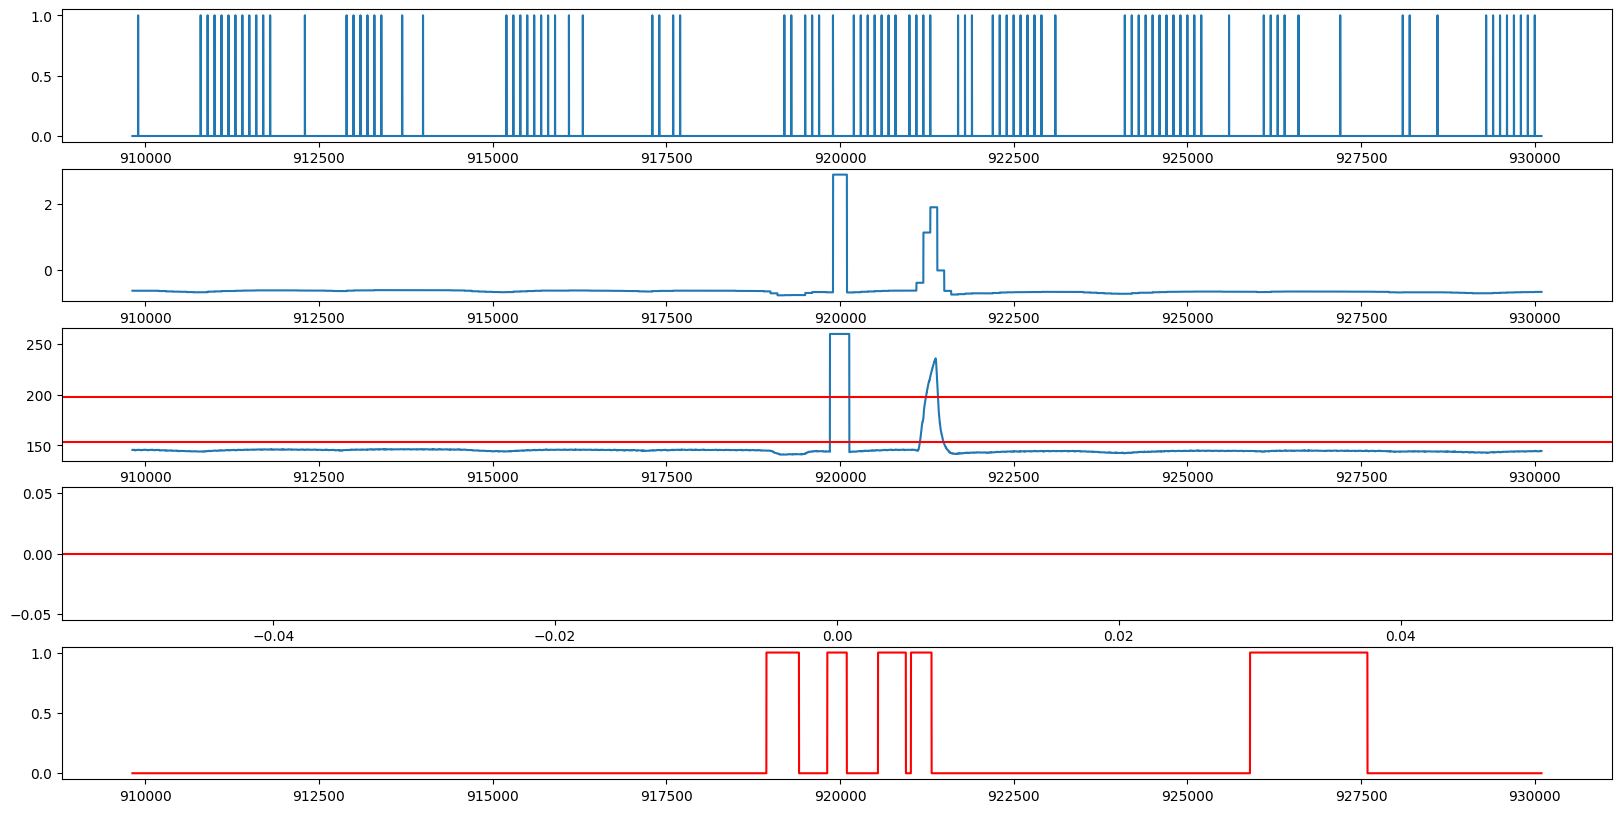

In [1106]:
for attack in get_index_attack('AIT402'):

    index_min, index_max = get_timestamp_attack(index_attack=attack, offset=10000)
    
    fig, ax = plt.subplots(5, 1, figsize=(20, 10))
    ax[0].plot(arr.iloc[index_min:index_max])
 
    ax[2].plot(df['AIT402'].iloc[index_min:index_max])
    ax[2].axhline(np.max(train['AIT402']), color='red')
    ax[2].axhline(np.min(train['AIT402']), color='red')

    ax[1].plot(df['AIT402_median'].iloc[index_min:index_max])

    # ax[1].axhline(y=0, color='r', linestyle='-')
   

    ax[3].plot(test_diff.iloc[index_min:index_max])
    ax[3].axhline(y=0, color='r', linestyle='-')

    ax[4].plot(df['Normal/Attack'].iloc[index_min:index_max], color='r')

In [1115]:
data_train = train[cols_numeric]
min_max_normalized_df = (data_train-data_train.min())/(data_train.max()-data_train.min())

In [1118]:
data = pd.DataFrame(columns=['col','quantile 0.05','quantile 0.25','quantile 0.5','quantile 0.75','quantile 0.95','quantile_var','polynom coef','min','max','mean','median','variance','std',])
for col in cols_continuous:
    p = np.polyfit([ i for i in range(len(min_max_normalized_df[col]))], min_max_normalized_df[col], 1)
    dict = {'col': col, 
            'quantile 0.05': np.quantile(min_max_normalized_df[col], 0.05),
            'quantile 0.25': np.quantile(min_max_normalized_df[col], 0.25),
            'quantile 0.5': np.quantile(min_max_normalized_df[col], 0.5),
            'quantile 0.75': np.quantile(min_max_normalized_df[col], 0.75),
            'quantile 0.95': np.quantile(min_max_normalized_df[col], 0.95),
            'quantile_var': np.var(np.quantile(min_max_normalized_df[col], [0.25, 0.5, 0.75])), 
            'polynom coef': p[0] * 100000,
            'min': np.min(min_max_normalized_df[col]), 
            'max': np.max(min_max_normalized_df[col]),
            'mean': np.mean(min_max_normalized_df[col]), 
            'median': np.median(min_max_normalized_df[col]),
            'variance': np.var(min_max_normalized_df[col]),
            'std': np.std(min_max_normalized_df[col]),
            }
    data = pd.concat([data, pd.DataFrame(dict, index=[0])], axis=0, ignore_index=True)

data_columns = list(data.columns)
data_columns.remove('col')
for col in data_columns:
    data[col] = data[col].apply(lambda x: np.round(x, 4))

In [1119]:
data['to_delete'] = data['quantile_var'] < 2
data.sort_values(by=['col'], ascending=False)

,col,quantile 0.05,quantile 0.25,quantile 0.5,quantile 0.75,quantile 0.95,quantile_var,polynom coef,min,max,mean,median,variance,std,to_delete
23,PIT503,0.1120,0.3063,0.5232,0.6722,0.7998,0.0226,-0.1193,0.0,1.0,0.4908,0.5232,0.0477,0.2185,True
22,PIT502,0.1857,0.2571,0.3143,0.3857,0.7286,0.0028,-0.0275,0.0,1.0,0.3710,0.3143,0.0289,0.1700,True
21,PIT501,0.1106,0.3201,0.5231,0.6617,0.7863,0.0197,-0.1102,0.0,1.0,0.4894,0.5231,0.0453,0.2129,True
12,LIT401,0.0752,0.3187,0.5219,0.7046,0.9308,0.0248,0.0021,0.0,1.0,0.5127,0.5219,0.0664,0.2577,True
8,LIT301,0.0591,0.2254,0.5923,0.7863,0.9839,0.0541,-0.0001,0.0,1.0,0.5342,0.5923,0.0965,0.3106,True
1,LIT101,0.0298,0.0700,0.1210,0.5957,0.9857,0.0560,-0.0065,0.0,1.0,0.3254,0.1210,0.1204,0.3469,True
24,FIT601,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,-0.0001,0.0,1.0,0.0081,0.0000,0.0071,0.0845,True
20,FIT504,0.2368,0.4053,0.5474,0.7053,0.7421,0.0150,-0.0793,0.0,1.0,0.5314,0.5474,0.0244,0.1561,True
19,FIT503,0.1801,0.3554,0.5118,0.6303,0.7536,0.0127,-0.1005,0.0,1.0,0.4865,0.5118,0.0338,0.1839,True
18,FIT502,0.2998,0.4027,0.4813,0.5828,0.7040,0.0054,0.0515,0.0,1.0,0.4926,0.4813,0.0155,0.1246,True


In [960]:
[len(arr[idx[i]:idx[i+1] + 1]) for i in range(0, len(idx), 2)]

array([   1,    2,    3, ..., 4453, 4455, 4456])

In [970]:

list_len = []
for col in cols_continuous:
    list_len.append(np.max(max_length_slope_test[max_length_slope_test[col] > 0]['max_length_slope_test']))
only_maxtest = pd.DataFrame(list_len).T
only_maxtest.columns = cols_continuous

only_maxtest = only_maxtest.fillna(0)

In [971]:
only_maxtest

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,AIT402,FIT401,LIT401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601
0,600,900,700,500,1000,700,600,700,800,400,700,700,700,600,600,1100,800,700,500,600,600,700,500,700,400


In [905]:
all_index = all_index[all_index['diff'] != 0] > 0
np.array(all_index['diff'])

array([False,  True, False, ...,  True, False,  True])

In [898]:
all_index

,diff
99,-0.202660
199,0.009236
299,-0.013986
399,0.017152
499,-0.006333
...,...
483699,-0.510082
483799,-0.011080
483899,0.009236
483999,-0.019791


In [ ]:

def get_islands(arr, mask):
    mask_ = np.concatenate(( [False], mask, [False] ))
    idx = np.flatnonzero(mask_ [1:] != mask_ [:-1])
    return [len(arr[idx[i]:idx[i+1] + 1]) for i in range(0, len(idx), 2)]

max_length = pd.DataFrame({
    'max_length': [i for i in range(1, 100000)],
})

for feature in cols_numeric:
    max_length_feature = pd.DataFrame(get_islands(np.diff(train[feature]), np.r_[np.diff(train[feature]) == 0, False]), columns=[feature])
    
    max_length_feature = max_length_feature[feature].value_counts().rename_axis('max_length').reset_index(name=feature)
    
    max_length = pd.merge(max_length, max_length_feature, on='max_length', how='left')
    
max_length = max_length.fillna(0)

list_len = []
for col in cols_numeric:
    list_len.append(np.max(max_length[max_length[col] > 0].index))
only_max = pd.DataFrame(list_len).T
only_max.columns = cols_numeric

only_max = only_max.fillna(0)

In [872]:
count_positive_slope = pd.DataFrame(columns=[cols_continuous])

max_length_positive = pd.DataFrame({
    'max_length': [i for i in range(1, 100000)],
})

max_length_negative = pd.DataFrame({
    'max_length': [i for i in range(1, 100000)],
})

for col in df_median_cols:
    for i in range(0, len(train), 100):
        

LIT301_median_slope
FIT101_median_slope
LIT101_median_slope
AIT201_median_slope
AIT202_median_slope
AIT203_median_slope
FIT201_median_slope
DPIT301_median_slope
FIT301_median_slope
AIT401_median_slope
AIT402_median_slope
FIT401_median_slope
LIT401_median_slope
AIT501_median_slope
AIT502_median_slope
AIT503_median_slope
AIT504_median_slope
FIT501_median_slope
FIT502_median_slope
FIT503_median_slope
FIT504_median_slope
PIT501_median_slope
PIT502_median_slope
PIT503_median_slope
FIT601_median_slope


In [891]:
pd.DataFrame(diff).value_counts()

0    483908
1       245
dtype: int64

In [895]:
mask = np.r_[np.diff(train[feature]) == 0, False]
arr = pd.DataFrame([i for i in range(0, len(train))])

mask_ = np.concatenate(( [False], mask, [False] ))
idx = np.flatnonzero(mask_ [1:] != mask_ [:-1])
max_ = pd.DataFrame([len(arr[idx[i]:idx[i+1] + 1]) for i in range(0, len(idx), 2)], columns=[feature])

max_ = max_[feature].value_counts().rename_axis('max_length').reset_index(name=feature)
max_


,max_length,P602
0,31,60
1,30,47
2,4110,16
3,4170,15
4,32,14
5,4290,11
6,4169,11
7,4230,7
8,4109,7
9,4289,6


In [900]:
mask

array([ True,  True,  True, ...,  True,  True, False])

In [896]:
# check if the past value is not changing for a long time for continuous feature

def get_islands(arr, mask):
    mask_ = np.concatenate(( [False], mask, [False] ))
    idx = np.flatnonzero(mask_ [1:] != mask_ [:-1])
    return [len(arr[idx[i]:idx[i+1] + 1]) for i in range(0, len(idx), 2)]

max_length = pd.DataFrame({
    'max_length': [i for i in range(1, 100000)],
})

for feature in cols_numeric:
    max_length_feature = pd.DataFrame(get_islands(np.diff(train[feature]), np.r_[np.diff(train[feature]) == 0, False]), columns=[feature])
    max_length_feature = max_length_feature[feature].value_counts().rename_axis('max_length').reset_index(name=feature)
    
    max_length = pd.merge(max_length, max_length_feature, on='max_length', how='left')
    
max_length = max_length.fillna(0)

list_len = []
for col in cols_numeric:
    list_len.append(np.max(max_length[max_length[col] > 0].index))
only_max = pd.DataFrame(list_len).T
only_max.columns = cols_numeric

only_max = only_max.fillna(0)

In [840]:
# Check if the past value is not changing for a long time for continuous feature
past_data = pd.DataFrame([0 for i in cols_numeric]).T
past_data.columns = cols_numeric

only_max_copy = only_max.copy()

def checking_sequence_of_zero(past_sequence_window):
    col_anomaly = []
    if len(past_sequence_window) < 2:
        return 0, []
    
    for col in cols_numeric:
        df_col = pd.DataFrame(past_sequence_window)[col]
        if df_col.iloc[-1] == df_col.iloc[-2]:
            past_data[col] += 1
        else:
            past_data[col] = 0
    
    for col in cols_numeric:
        if past_data[col].values[0] > only_max_copy[col].values[0] and only_max_copy[col].values[0] > 0:
            col_anomaly.append(col)
    
    # for col in cols_continuous:
    #     if np.var(pd.DataFrame(past_sequence_window[0:len(past_sequence_window)])[col]) == 0:
    #         col_anomaly.append(col)
    if len(col_anomaly) > 0:
        return 1, col_anomaly
    return 0, []

### Algorithm to check value from variance train zero

In [626]:
# Check if the value of np.var == 0 in the train is not the value mean value in the test

df_var_zero = pd.DataFrame(columns=['col', 'mean'])
for col in cols_numeric:
    if np.var(train[col]) == 0:
        df_var_zero = pd.concat(objs=[df_var_zero, pd.DataFrame({'col': [col], 'mean': [train[col].mean()]})], axis=0, ignore_index=True)

def checking_not_null(row):
    col_anomaly = []
    for col in df_var_zero['col']:
        if row[col] != df_var_zero[df_var_zero['col'] == col]['mean'].values[0]:
            col_anomaly.append(col)
    if len(col_anomaly) > 0:
        return 1, col_anomaly
    return 0, []

### Algorithm to check if the last sequence of state have a probability to happen

#### Get Median

In [ ]:

# n = 100

# for col in cols_continuous:
#     median_ = pd.DataFrame(columns=['x', 'y'])
#     for i in range(0, len(df_normalized), n):
#         med = np.median(df_normalized.iloc[i:i+n][col])
#         a = n
#         if i+n > len(df_normalized):
#             a = len(df_normalized) - i
#         median_ = pd.concat(objs=[median_, pd.DataFrame({'x': [i for i in range(i, i+a)], 'y': [med for i in range(i, i+a)]})], axis=0)
#     df[f'{col}_median'] = median_['y'].reset_index(drop=True)
    
# # ~38 mins

In [ ]:
median_cols = [col for col in df.columns if 'median' in col]

#### Get Slope

In [156]:
def get_slope_feature(df, col, window_size):
    df_copy = df[col].copy()

    slope_feature = [0] * 1 + [ x for x in np.diff(np.array(df_copy[col]))]#1 if x > 0 else -1 for

    slope_x = pd.DataFrame(slope_feature, columns=['slope'])
    
    slope_adjusted = []
    for i in range(0, len(slope_x), n):
        
        a = window_size
        if i+window_size > len(slope_x):
            a = len(slope_x) - i
            slope_adjusted += [slope_x['slope'].iloc[i+a-1] for x in range(a)]
        else:
            slope_adjusted += [slope_x['slope'].iloc[i+a] for x in range(a)]
    
    return pd.DataFrame(slope_adjusted)

In [ ]:
for col in median_cols:
    slope_feature = get_slope_feature(df, [col], 100)
    df[col+'_slope'] = slope_feature

In [ ]:
slope_cols = [col for col in df.columns if 'median_slope' in col]

In [ ]:
def get_discrete_median(row, quantiles):
    # point = [i for i in range(quantiles)]
    for i, quantile in enumerate(quantiles):
        if row <= quantile:
            return i
        
    return len(quantiles) - 1

In [ ]:
for col in slope_cols:
    quantiles = np.quantile(train[col], [0.01, 0.99])
    discrete_col = col.replace('median_slope', '')
    df[discrete_col+'discrete'] = df[col].apply(lambda x: get_discrete_median(x, quantiles))

#### Get state

In [696]:
discrete_cols = []
for col in df.columns:
    if 'discrete' in col or col in cols_discrete:
        discrete_cols.append(col)

In [692]:
def set_sequence(row):
    sequence = str('')
    for value in row:
        sequence += str(value)
    return sequence

In [698]:
df['state'] = df[discrete_cols].apply(lambda row: set_sequence(row), axis=1)

In [699]:
train, test = get_train_test_dataset(df)

#### Get the Transition Matrix

In [704]:
data_matrix_train = train.copy()#[cols_numeric].values

In [705]:
k = len(data_matrix_train['state'].unique())

In [706]:
df_state = data_matrix_train['state'].unique()
df_state = pd.DataFrame(df_state)
df_state.columns = ['state']

df_state = df_state.sort_values(by=['state'])
df_state = df_state.reset_index(drop=True)
df_state = df_state.reset_index()

In [707]:
matrix = np.zeros((k, k), dtype=int)
sum_state = np.zeros((k, 1), dtype=int)

In [709]:
for i in range(len(data_matrix_train)-1):# 450.000
    state_before = data_matrix_train.iloc[i]['state']
    state_after  = data_matrix_train.iloc[i+1]['state']
    
    false_state_before = df_state[df_state['state'] == state_before]['index'].values[0]
    false_state_after  = df_state[df_state['state'] == state_after]['index'].values[0]

    sum_state[false_state_before] += 1
    matrix[false_state_before][false_state_after] += 1
    
# ~34 min for 4000 states
# ~8 mins for 500 states

In [710]:
df_count_state = data_matrix_train['state'].value_counts().rename_axis('state').reset_index(name='counts')
df_merge_count = pd.merge(df_state, df_count_state, on='state', how='left')
sum_state = df_merge_count['counts'].values

In [711]:
transition_matrix = matrix / sum_state
transition_matrix = np.nan_to_num(transition_matrix)
df_transition_matrix = pd.DataFrame(transition_matrix)

In [1120]:
# df_transition_matrix.to_csv('markov/transition_matrix.csv', index=False)

In [ ]:
df_transition_matrix = pd.read_csv(filepath_or_buffer='markov/transition_matrix.csv')

In [712]:
df_prob = (sum_state / len(data_matrix_train))
df_prob = np.nan_to_num(df_prob)
df_prob = np.array(df_prob.tolist())

#### Algorithm to check the probability of a sequence 

In [819]:
def checking_state_probability(past_sequence_window):
    col_anomaly = []
    if len(past_sequence_window) < 2:
        return 0, []

    probabilities = np.zeros(len(past_sequence_window))
    
    state = pd.DataFrame(past_sequence_window)['state'].iloc[0]
    index_previous_state = -1
    if len(df_state[df_state['state'] == state]['index']) == 0:
        probabilities[0] = 0
    else:
        index_previous_state = df_state[df_state['state'] == state]['index'].values[0]
        probabilities[0] = df_prob[index_previous_state]
    
    for i in range(1, len(past_sequence_window)):
        state = pd.DataFrame(past_sequence_window)['state'].iloc[i]
        
        if len(df_state[df_state['state'] == state]['index']) == 0:
            probabilities[i] = 0
        else:
            index = df_state[df_state['state'] == state]['index'].values[0]
            if index_previous_state == -1:
                probabilities[i] = df_prob[index]
            else:
                probabilities[i] = transition_matrix[index_previous_state][index]
            
            index_previous_state = index
        
    if np.prod(probabilities) == 0:
        return 1, []
    else:
        return 0, []

## Multimodel Anomaly Detection

In [772]:
train, test = get_train_test_dataset(df)

In [848]:
# past_sequence_window = []
window_size = 30

columns = ['Timestamp', 'Anomaly', 'Anomaly State', 'Anomaly MinMax', 'Anomaly Sequence Var Zero', 'Anomaly Not Null']+cols_numeric
# anomaly_detection = pd.DataFrame(columns=columns)


n = len(anomaly_detection)#len(test)
for i in range(n, n+2000):
    row = test.iloc[i]
    
    Timestamp = row['Timestamp']
    
    # update the past sequence window
    if len(past_sequence_window) < window_size:
        past_sequence_window.append(row)
    else:
        past_sequence_window.pop(0)
        past_sequence_window.append(row)
    
    anomaly_t = pd.DataFrame(columns=columns)
    anomaly_t['Timestamp'] = [Timestamp]
    anomaly_t = anomaly_t.fillna(0)

    
    anomaly_min_max, cols = checking_min_max(row)
    if anomaly_min_max == 1:
        # print('anomaly min max', Timestamp, cols)
        for col in cols:
            anomaly_t[col] += 1
            anomaly_t['Anomaly MinMax'] += 1
            anomaly_t['Anomaly'] += 1
    
    anomaly_sequence, cols = checking_sequence_of_zero(past_sequence_window)
    if anomaly_sequence == 1:
        # print('anomaly sequence', Timestamp, cols)
        for col in cols:
            anomaly_t[col] += 1
            anomaly_t['Anomaly Sequence Var Zero'] += 1
            anomaly_t['Anomaly'] += 1
    
    anomaly_not_null, cols = checking_not_null(row)
    if anomaly_not_null == 1:
        # print('anomaly not null', Timestamp, cols)
        for col in cols:
            anomaly_t[col] += 1
            anomaly_t['Anomaly Not Null'] += 1
            anomaly_t['Anomaly'] += 1
    
    anomaly_state, cols = checking_state_probability(past_sequence_window)
    if anomaly_state == 1:
        # print('anomaly state probability', Timestamp, cols)
        anomaly_t['Anomaly State'] = 1
        anomaly_t['Anomaly'] += 1
        
    anomaly_detection = pd.concat(objs=[anomaly_detection, anomaly_t], axis=0, ignore_index=True)

anomaly_detection = anomaly_detection.fillna(0)

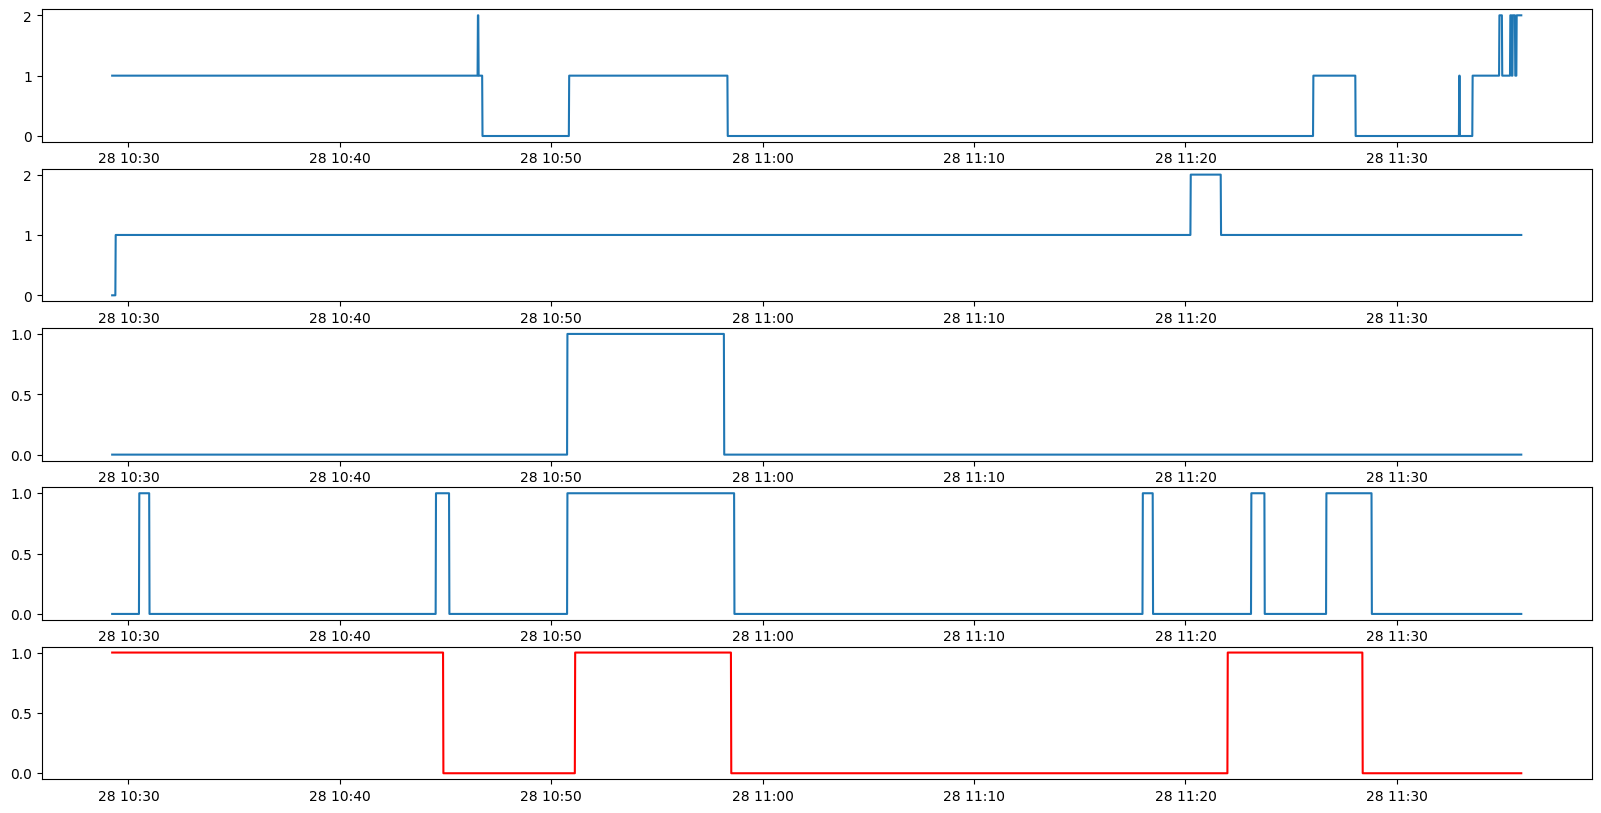

In [852]:
fig, ax = plt.subplots(5, 1, figsize=(20, 10))
ax[0].plot(anomaly_detection['Timestamp'], anomaly_detection['Anomaly MinMax'])
ax[1].plot(anomaly_detection['Timestamp'], anomaly_detection['Anomaly Sequence Var Zero'])
ax[2].plot(anomaly_detection['Timestamp'], anomaly_detection['Anomaly Not Null'])
ax[3].plot(anomaly_detection['Timestamp'], anomaly_detection['Anomaly State'])
ax[4].plot(anomaly_detection['Timestamp'], test.iloc[:len(anomaly_detection)]['Normal/Attack'].reset_index(drop=True), color='red')